# 导入需要的包

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import os
import time
import numpy as np
import matplotlib.pyplot as plt

# 设置中文支持
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号'-'显示为方块的问题

# 导入数据集

In [16]:
# 提前下载好数据集并放至同目录下
train_dataset = torchvision.datasets.MNIST(
    root="./MNIST", train=True, transform=transforms.ToTensor(), download=False
)
test_dataset = torchvision.datasets.MNIST(
    root="./MNIST", train=False, transform=transforms.ToTensor(), download=False
)

# 加载数据集
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

print("num_train:", len(train_loader.dataset))
print("num_test:", len(test_loader.dataset))

num_train: 60000
num_test: 10000


In [17]:
# 定义画图函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(dpi=100)
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label="train", color="red", linewidth=1)
    plt.plot(x, test_loss, label="test", color="blue", linewidth=1)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


# 定义损失、精度评估函数
def evaluate_accuracy(data_iter, model, loss_func):
    acc_sum, test_l_sum, n, c = 0.0, 0.0, 0.0, 0.0
    for X, y in data_iter:
        result = model.forward(X)
        result = torch.round(result)
        acc_sum += (result.argmax(dim=1) == y).sum().item()
        test_l_sum += loss_func(result, y.flatten().long()).item()
        n += y.shape[0]
        c += 1
    return acc_sum / n, test_l_sum / c

# 1. 多分类任务：手动实现部分

## 1.1 手动构建前馈神经网络模型

In [4]:
class FeedForwardNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        W1 = torch.tensor(
            np.random.normal(0, 0.01, size=(hidden_dim, input_dim)),
            dtype=torch.float32,
        )
        b1 = torch.zeros(hidden_dim, dtype=torch.float32)
        W2 = torch.tensor(
            np.random.normal(0, 0.01, size=(output_dim, hidden_dim)),
            dtype=torch.float32,
        )
        b2 = torch.zeros(output_dim, dtype=torch.float32)
        # save params
        self.params = [W1, b1, W2, b2]
        for param in self.params:
            param.requires_grad = True

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_ReLU(torch.matmul(x, W1.T) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.T) + b2

    @staticmethod
    def my_ReLU(x):
        return torch.max(input=x, other=torch.tensor(0.0))

    def forward(self, x):
        # 定义模型前向传播过程
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        final_output = self.output_layer(hidden_output)
        return final_output


# 交叉熵损失函数
def cross_entropy_loss(y_hat, labels):
    def log_softmax(y_hat):
        max_v = torch.max(y_hat, dim=1).values.unsqueeze(dim=1)
        return (
            y_hat
            - max_v
            - torch.log(torch.exp(y_hat - max_v).sum(dim=1)).unsqueeze(dim=1)
        )

    return (-log_softmax(y_hat))[range(len(y_hat)), labels].mean()


# 定义优化算法
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad


# 定义模型训练函数
def train(model, train_loader, test_loader, loss, optimizer, num_epochs, lr=None):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0

        for X, y in train_loader:
            # 前向传播
            y_hat = model.forward(X)
            # 计算损失
            l = loss(y_hat, y.flatten().long()).sum()
            # 反向传播
            l.backward()
            # 参数优化更新
            optimizer(model.params, lr)
            # 梯度清零
            for param in model.params:
                param.grad.data.zero_()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]

        # 计算每轮epoch的损失和准确率
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)

        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )
    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

epoch 1, train_loss 2.1704,test_loss 1.8922 train acc 0.530 test acc 0.395
epoch 2, train_loss 1.2889,test_loss 0.8809 train acc 0.751 test acc 0.740
epoch 3, train_loss 0.7128,test_loss 0.5963 train acc 0.831 test acc 0.822
epoch 4, train_loss 0.5407,test_loss 0.4875 train acc 0.863 test acc 0.859
epoch 5, train_loss 0.4624,test_loss 0.4253 train acc 0.878 test acc 0.874
epoch 6, train_loss 0.4179,test_loss 0.3916 train acc 0.888 test acc 0.885
epoch 7, train_loss 0.3892,test_loss 0.3679 train acc 0.893 test acc 0.893
epoch 8, train_loss 0.3690,test_loss 0.3512 train acc 0.898 test acc 0.897
epoch 9, train_loss 0.3536,test_loss 0.3383 train acc 0.901 test acc 0.900
epoch 10, train_loss 0.3413,test_loss 0.3292 train acc 0.904 test acc 0.902
epoch 11, train_loss 0.3306,test_loss 0.3167 train acc 0.906 test acc 0.906
epoch 12, train_loss 0.3218,test_loss 0.3111 train acc 0.909 test acc 0.909
epoch 13, train_loss 0.3138,test_loss 0.3031 train acc 0.911 test acc 0.912
epoch 14, train_loss 

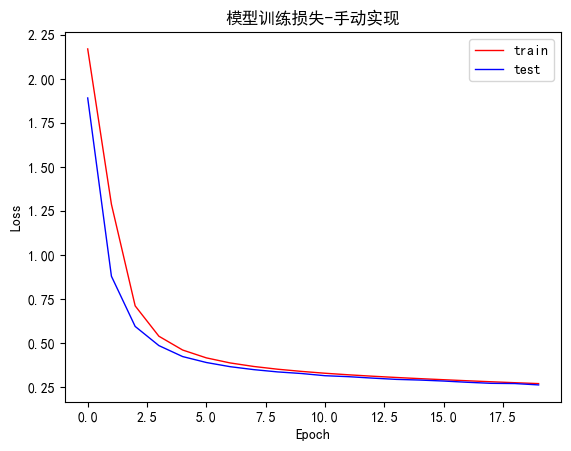

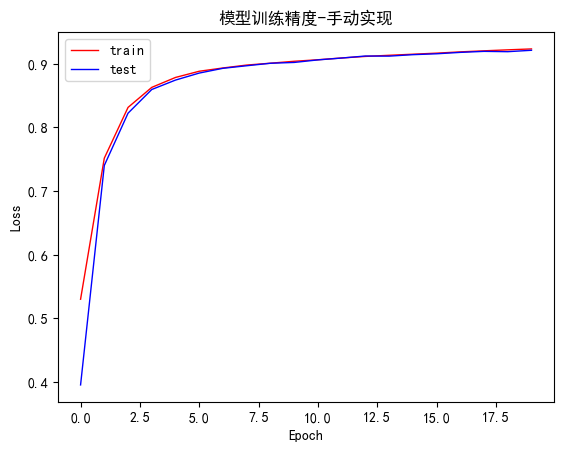

In [29]:
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(
    model, train_loader, test_loader, cross_entropy_loss, SGD, num_epochs, lr
)

plot_loss(train_loss_list, test_loss_list, "模型训练损失-手动实现")

plot_loss(train_acc_list, test_acc_list, "模型训练精度-手动实现")

## 1.2 手动实现momentum、rmsprop、Adam优化器，并进行优化器的对比实验

### 1.2.1 momentum优化器手动实现并训练

In [ ]:
# 初始化参数
def init_momentum_states(params):
    v_w1, v_b1, v_w2, v_b2 = (
        torch.zeros(params[0].shape),
        torch.zeros(params[1].shape),
        torch.zeros(params[2].shape),
        torch.zeros(params[3].shape),
    )
    return (v_w1, v_b1, v_w2, v_b2)


# momentum优化算法
def sgd_momentum(params, states, lr, momentum):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = momentum * v - p.grad
            p[:] += lr * v
        p.grad.zero_()


# 修改的训练函数
def train_m(
    model,
    train_loader,
    test_loader,
    loss,
    optimizer,
    num_epochs,
    lr=None,
    statefunc=None,
):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    states = statefunc(model.params)
    momentum = 0.5

    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            y_hat = model.forward(X)
            l = loss(y_hat, y.flatten().long()).sum()
            l.backward()
            optimizer(model.params, states, lr, momentum)
            for param in model.params:
                param.grad.data.zero_()
            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)
        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
train_m_loss_list, test_m_loss_list, train_m_acc_list, test_m_acc_list = train_m(
    model,
    train_loader,
    test_loader,
    cross_entropy_loss,
    sgd_momentum,
    num_epochs,
    lr,
    init_momentum_states,
)

epoch 1, train_loss 1.7215,test_loss 0.8730 train acc 0.638 test acc 0.731
epoch 2, train_loss 0.6267,test_loss 0.4894 train acc 0.847 test acc 0.863
epoch 3, train_loss 0.4419,test_loss 0.3945 train acc 0.882 test acc 0.885
epoch 4, train_loss 0.3809,test_loss 0.3507 train acc 0.894 test acc 0.896
epoch 5, train_loss 0.3484,test_loss 0.3266 train acc 0.902 test acc 0.903
epoch 6, train_loss 0.3268,test_loss 0.3102 train acc 0.907 test acc 0.907
epoch 7, train_loss 0.3105,test_loss 0.2972 train acc 0.912 test acc 0.910
epoch 8, train_loss 0.2966,test_loss 0.2835 train acc 0.916 test acc 0.916
epoch 9, train_loss 0.2844,test_loss 0.2737 train acc 0.919 test acc 0.918
epoch 10, train_loss 0.2732,test_loss 0.2637 train acc 0.922 test acc 0.921
epoch 11, train_loss 0.2631,test_loss 0.2555 train acc 0.925 test acc 0.924
epoch 12, train_loss 0.2538,test_loss 0.2471 train acc 0.928 test acc 0.927
epoch 13, train_loss 0.2450,test_loss 0.2395 train acc 0.930 test acc 0.929
epoch 14, train_loss 

### 1.2.2 rmsprop优化器手动实现并训练

In [ ]:
# 初始化参数
def init_rmsprop_states(params):
    s_w1, s_b1, s_w2, s_b2 = (
        torch.zeros(params[0].shape),
        torch.zeros(params[1].shape),
        torch.zeros(params[2].shape),
        torch.zeros(params[3].shape),
    )
    return (s_w1, s_b1, s_w2, s_b2)


# 定义优化算法
def rmsprop(params, states, lr, gamma):
    gamma, eps = gamma, 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= lr * p.grad / torch.sqrt(s + eps)
        p.grad.zero_()


def train_r(
    model,
    train_loader,
    test_loader,
    loss,
    optimizer,
    num_epochs,
    lr=None,
    statefunc=None,
):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    states = statefunc(model.params)
    gamma = 0.9
    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            y_hat = model.forward(X)
            l = loss(y_hat, y.flatten().long()).sum()
            l.backward()
            optimizer(model.params, states, lr, gamma)
            for param in model.params:
                param.grad.data.zero_()
            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)
        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
train_r_loss_list, test_r_loss_list, train_r_acc_list, test_r_acc_list = train_r(
    model,
    train_loader,
    test_loader,
    cross_entropy_loss,
    rmsprop,
    num_epochs,
    lr,
    init_rmsprop_states,
)

epoch 1, train_loss 0.2784,test_loss 0.1220 train acc 0.913 test acc 0.959
epoch 2, train_loss 0.1126,test_loss 0.1100 train acc 0.967 test acc 0.968
epoch 3, train_loss 0.0892,test_loss 0.1078 train acc 0.975 test acc 0.971
epoch 4, train_loss 0.0736,test_loss 0.1035 train acc 0.979 test acc 0.973
epoch 5, train_loss 0.0609,test_loss 0.0898 train acc 0.983 test acc 0.978
epoch 6, train_loss 0.0550,test_loss 0.1379 train acc 0.984 test acc 0.975
epoch 7, train_loss 0.0483,test_loss 0.1297 train acc 0.987 test acc 0.972
epoch 8, train_loss 0.0434,test_loss 0.1484 train acc 0.988 test acc 0.972
epoch 9, train_loss 0.0380,test_loss 0.1255 train acc 0.990 test acc 0.977
epoch 10, train_loss 0.0305,test_loss 0.1247 train acc 0.991 test acc 0.979
epoch 11, train_loss 0.0278,test_loss 0.1405 train acc 0.992 test acc 0.976
epoch 12, train_loss 0.0263,test_loss 0.1668 train acc 0.993 test acc 0.976
epoch 13, train_loss 0.0237,test_loss 0.1718 train acc 0.994 test acc 0.975
epoch 14, train_loss 

### 1.2.3 Adam优化器手动实现并训练

In [ ]:
# 初始化
def init_adam_states(params):
    v_w1, v_b1, v_w2, v_b2 = (
        torch.zeros(params[0].shape),
        torch.zeros(params[1].shape),
        torch.zeros(params[2].shape),
        torch.zeros(params[3].shape),
    )
    s_w1, s_b1, s_w2, s_b2 = (
        torch.zeros(params[0].shape),
        torch.zeros(params[1].shape),
        torch.zeros(params[2].shape),
        torch.zeros(params[3].shape),
    )
    return ((v_w1, s_w1), (v_b1, s_b1), (v_w2, s_w2), (v_b2, s_b2))


# 定义优化器
def adam(params, states, lr, t):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad / (1 - pow(beta1, t))
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad) / (1 - pow(beta2, t))
            p[:] = p - lr * v / torch.sqrt(s + eps)
        p.grad.zero_()
    t += 1


def train_a(
    model,
    train_loader,
    test_loader,
    loss,
    optimizer,
    num_epochs,
    lr=None,
    statefunc=None,
):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    states = statefunc(model.params)
    t = 1
    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            y_hat = model.forward(X)
            l = loss(y_hat, y.flatten().long()).sum()
            l.backward()
            optimizer(model.params, states, lr, t)
            for param in model.params:
                param.grad.data.zero_()
            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)
        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
train_a_loss_list, test_a_loss_list, train_a_acc_list, test_a_acc_list = train_a(
    model,
    train_loader,
    test_loader,
    cross_entropy_loss,
    adam,
    num_epochs,
    lr,
    init_adam_states,
)

epoch 1, train_loss 0.2038,test_loss 0.1007 train acc 0.936 test acc 0.965
epoch 2, train_loss 0.0736,test_loss 0.0800 train acc 0.977 test acc 0.973
epoch 3, train_loss 0.0483,test_loss 0.0735 train acc 0.985 test acc 0.977
epoch 4, train_loss 0.0333,test_loss 0.0786 train acc 0.989 test acc 0.974
epoch 5, train_loss 0.0256,test_loss 0.0688 train acc 0.992 test acc 0.978
epoch 6, train_loss 0.0192,test_loss 0.0793 train acc 0.994 test acc 0.977
epoch 7, train_loss 0.0143,test_loss 0.0880 train acc 0.995 test acc 0.978
epoch 8, train_loss 0.0155,test_loss 0.0895 train acc 0.994 test acc 0.977
epoch 9, train_loss 0.0156,test_loss 0.0845 train acc 0.995 test acc 0.980
epoch 10, train_loss 0.0088,test_loss 0.0935 train acc 0.997 test acc 0.978
epoch 11, train_loss 0.0091,test_loss 0.0905 train acc 0.997 test acc 0.979
epoch 12, train_loss 0.0084,test_loss 0.1004 train acc 0.997 test acc 0.978
epoch 13, train_loss 0.0117,test_loss 0.1074 train acc 0.996 test acc 0.977
epoch 14, train_loss 

### 1.2.4 三种优化算法的实验结果比较

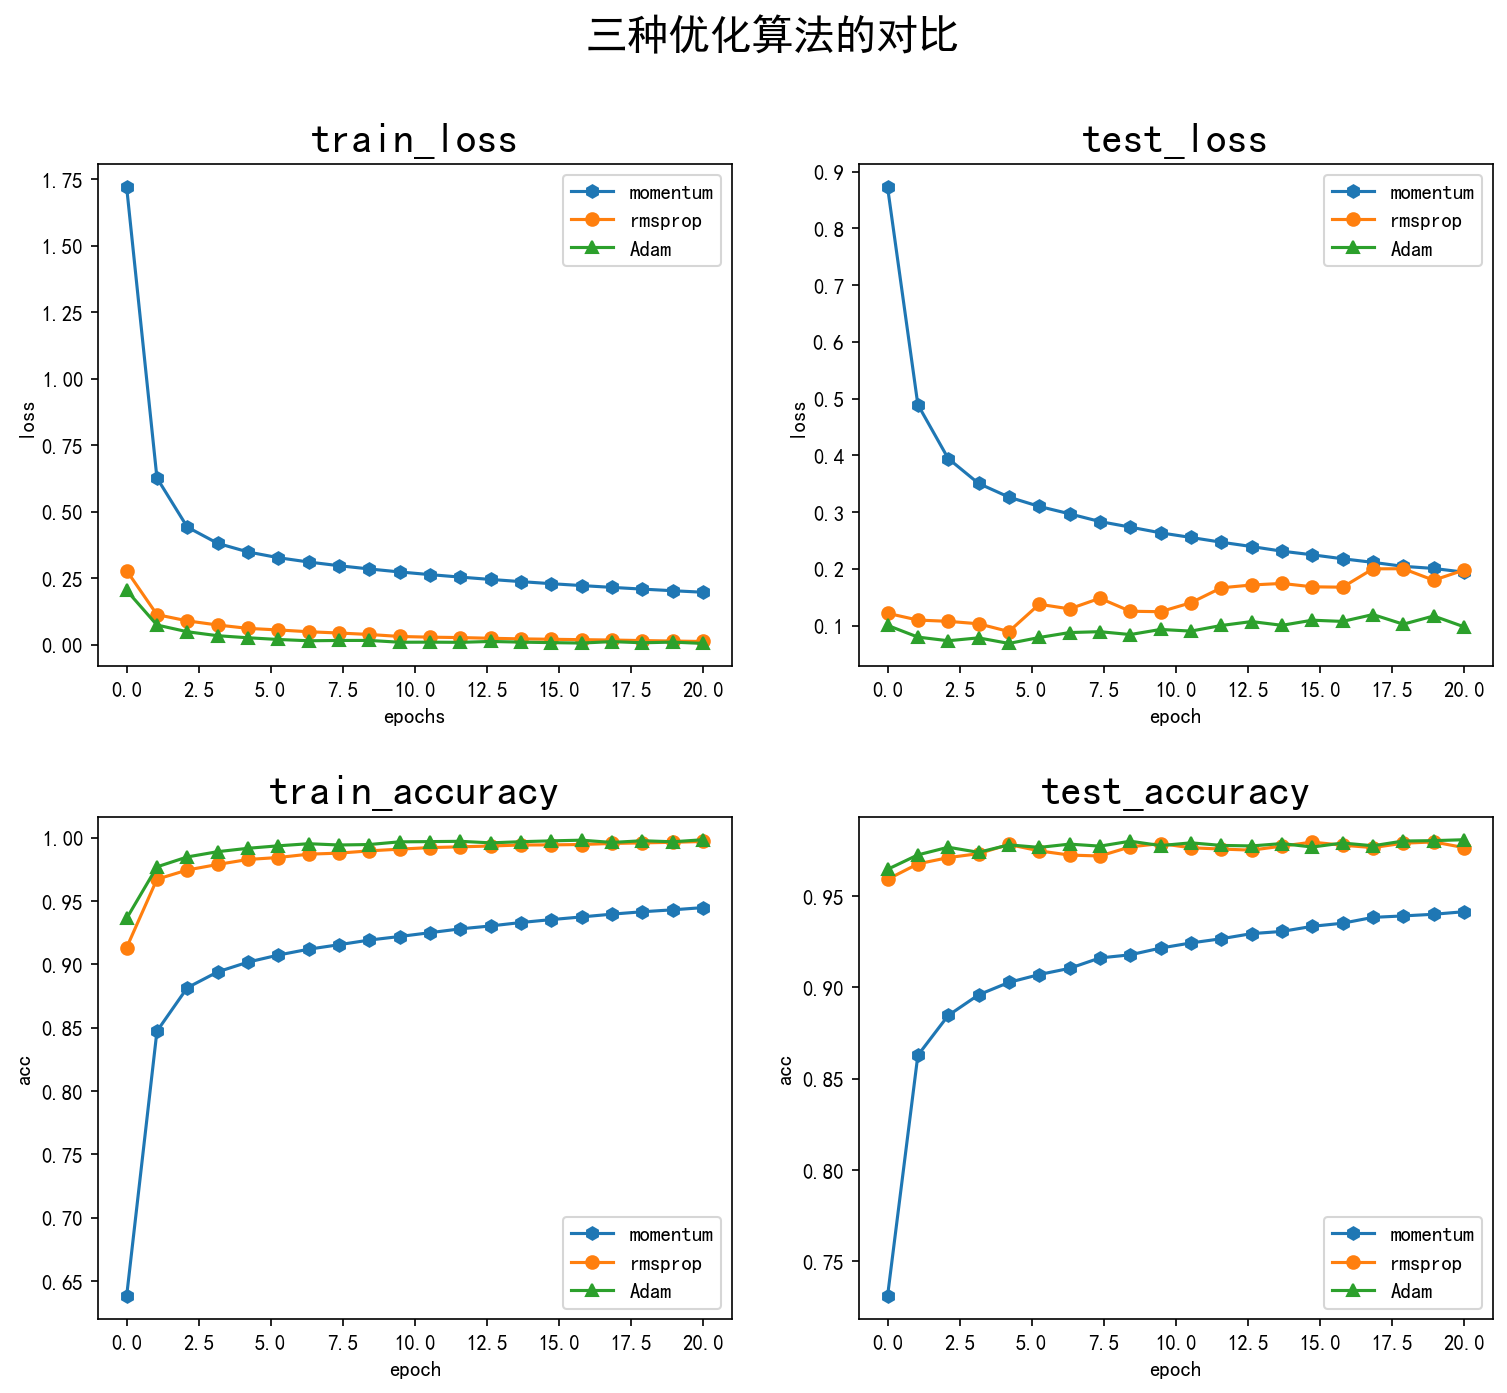

In [ ]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("三种优化算法的对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_m_loss_list), len(train_m_loss_list))
ax1.plot(x, train_m_loss_list, label="momentum", marker="h", linewidth=1.5)
ax1.plot(x, train_r_loss_list, label="rmsprop", marker="o", linewidth=1.5)
ax1.plot(x, train_a_loss_list, label="Adam", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_m_loss_list, label="momentum", marker="h", linewidth=1.5)
ax2.plot(x, test_r_loss_list, label="rmsprop", marker="o", linewidth=1.5)
ax2.plot(x, test_a_loss_list, label="Adam", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_m_acc_list, label="momentum", marker="h", linewidth=1.5)
ax3.plot(x, train_r_acc_list, label="rmsprop", marker="o", linewidth=1.5)
ax3.plot(x, train_a_acc_list, label="Adam", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_m_acc_list, label="momentum", marker="h", linewidth=1.5)
ax4.plot(x, test_r_acc_list, label="rmsprop", marker="o", linewidth=1.5)
ax4.plot(x, test_a_acc_list, label="Adam", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

#### 结论
Adam优化器的分类效果最好，损失值最小且分类的准确率最高，而rmsprop优化器的分类准确率稍低点，但和Adam优化器相差不大，momentum优化器的分类准确率最低，且与Adam优化器和rmsprop优化器性能差距较大

## 1.3 手动实现L2正则化，进行惩罚项权重的对比实验

In [ ]:
# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2


# 定义L2范数惩罚的训练函数
def trainL2(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr=None, lambd=0
):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            # 前向传播
            y_hat = model.forward(X)
            # 计算损失
            l = (
                loss(y_hat, y.flatten().long()).sum()
                + lambd * l2_penalty(model.params[0])
                + lambd * l2_penalty(model.params[2])
            )
            # 反向传播
            l.backward()
            # 优化参数
            optimizer(model.params, lr)
            # 梯度清零
            for param in model.params:
                param.grad.data.zero_()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)
        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

### 1.3.1 weight=0.1

In [ ]:
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
lambd = 1e-1
loss = nn.CrossEntropyLoss()
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
(
    train_loss_list_L2Norm1,
    test_loss_list_L2Norm1,
    train_acc_list_L2Norm1,
    test_acc_list_L2Norm1,
) = trainL2(
    model,
    train_loader,
    test_loader,
    loss,
    SGD,
    num_epochs,
    lr,
    lambd,
)

epoch 1, train_loss 2.9024,test_loss 2.2275 train acc 0.463 test acc 0.100
epoch 2, train_loss 2.1460,test_loss 1.3918 train acc 0.637 test acc 0.575
epoch 3, train_loss 1.6965,test_loss 1.0712 train acc 0.748 test acc 0.665
epoch 4, train_loss 1.5683,test_loss 0.9583 train acc 0.797 test acc 0.718
epoch 5, train_loss 1.5239,test_loss 0.9130 train acc 0.819 test acc 0.734
epoch 6, train_loss 1.5055,test_loss 0.8874 train acc 0.830 test acc 0.753
epoch 7, train_loss 1.4965,test_loss 0.8726 train acc 0.836 test acc 0.763
epoch 8, train_loss 1.4915,test_loss 0.8667 train acc 0.840 test acc 0.766
epoch 9, train_loss 1.4879,test_loss 0.8610 train acc 0.844 test acc 0.769
epoch 10, train_loss 1.4853,test_loss 0.8567 train acc 0.845 test acc 0.772
epoch 11, train_loss 1.4830,test_loss 0.8537 train acc 0.846 test acc 0.760
epoch 12, train_loss 1.4811,test_loss 0.8500 train acc 0.847 test acc 0.773
epoch 13, train_loss 1.4795,test_loss 0.8473 train acc 0.848 test acc 0.775
epoch 14, train_loss 

### 1.3.2 weight=0.05

In [ ]:
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
lambd = 0.05
loss = nn.CrossEntropyLoss()
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
(
    train_loss_list_L2Norm2,
    test_loss_list_L2Norm2,
    train_acc_list_L2Norm2,
    test_acc_list_L2Norm2,
) = trainL2(
    model,
    train_loader,
    test_loader,
    loss,
    SGD,
    num_epochs,
    lr,
    lambd,
)

epoch 1, train_loss 2.6049,test_loss 2.0487 train acc 0.529 test acc 0.256
epoch 2, train_loss 1.8615,test_loss 1.1121 train acc 0.705 test acc 0.661
epoch 3, train_loss 1.3918,test_loss 0.8137 train acc 0.799 test acc 0.759
epoch 4, train_loss 1.2474,test_loss 0.7102 train acc 0.836 test acc 0.793
epoch 5, train_loss 1.1834,test_loss 0.6636 train acc 0.854 test acc 0.821
epoch 6, train_loss 1.1479,test_loss 0.6359 train acc 0.864 test acc 0.825
epoch 7, train_loss 1.1266,test_loss 0.6201 train acc 0.870 test acc 0.838
epoch 8, train_loss 1.1130,test_loss 0.6077 train acc 0.874 test acc 0.846
epoch 9, train_loss 1.1039,test_loss 0.6010 train acc 0.877 test acc 0.850
epoch 10, train_loss 1.0976,test_loss 0.5961 train acc 0.878 test acc 0.851
epoch 11, train_loss 1.0933,test_loss 0.5925 train acc 0.880 test acc 0.853
epoch 12, train_loss 1.0900,test_loss 0.5867 train acc 0.881 test acc 0.857
epoch 13, train_loss 1.0875,test_loss 0.5849 train acc 0.882 test acc 0.855
epoch 14, train_loss 

### 1.3.3 weight=0.01

In [ ]:
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
lambd = 0.01
loss = nn.CrossEntropyLoss()
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
(
    train_loss_list_L2Norm3,
    test_loss_list_L2Norm3,
    train_acc_list_L2Norm3,
    test_acc_list_L2Norm3,
) = trainL2(
    model,
    train_loader,
    test_loader,
    loss,
    SGD,
    num_epochs,
    lr,
    lambd,
)

epoch 1, train_loss 2.2618,test_loss 1.8725 train acc 0.561 test acc 0.419
epoch 2, train_loss 1.4202,test_loss 0.9150 train acc 0.739 test acc 0.718
epoch 3, train_loss 0.9120,test_loss 0.6383 train acc 0.829 test acc 0.807
epoch 4, train_loss 0.7633,test_loss 0.5252 train acc 0.860 test acc 0.849
epoch 5, train_loss 0.6989,test_loss 0.4686 train acc 0.875 test acc 0.868
epoch 6, train_loss 0.6630,test_loss 0.4350 train acc 0.884 test acc 0.878
epoch 7, train_loss 0.6401,test_loss 0.4121 train acc 0.889 test acc 0.885
epoch 8, train_loss 0.6237,test_loss 0.3973 train acc 0.893 test acc 0.886
epoch 9, train_loss 0.6113,test_loss 0.3837 train acc 0.897 test acc 0.890
epoch 10, train_loss 0.6014,test_loss 0.3729 train acc 0.899 test acc 0.895
epoch 11, train_loss 0.5931,test_loss 0.3664 train acc 0.901 test acc 0.897
epoch 12, train_loss 0.5861,test_loss 0.3583 train acc 0.903 test acc 0.901
epoch 13, train_loss 0.5798,test_loss 0.3536 train acc 0.904 test acc 0.902
epoch 14, train_loss 

### 1.3.4 weight=0.001

In [ ]:
input_dim = 784
hidden_dim = 256
output_dim = 10
lr = 0.01
num_epochs = 20
lambd = 0.001
loss = nn.CrossEntropyLoss()
model = FeedForwardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# 训练模型
(
    train_loss_list_L2Norm4,
    test_loss_list_L2Norm4,
    train_acc_list_L2Norm4,
    test_acc_list_L2Norm4,
) = trainL2(
    model,
    train_loader,
    test_loader,
    loss,
    SGD,
    num_epochs,
    lr,
    lambd,
)

epoch 1, train_loss 2.1711,test_loss 1.8554 train acc 0.517 test acc 0.424
epoch 2, train_loss 1.2930,test_loss 0.8860 train acc 0.749 test acc 0.726
epoch 3, train_loss 0.7355,test_loss 0.6037 train acc 0.831 test acc 0.813
epoch 4, train_loss 0.5669,test_loss 0.4917 train acc 0.863 test acc 0.855
epoch 5, train_loss 0.4914,test_loss 0.4311 train acc 0.878 test acc 0.874
epoch 6, train_loss 0.4491,test_loss 0.3973 train acc 0.886 test acc 0.883
epoch 7, train_loss 0.4222,test_loss 0.3738 train acc 0.892 test acc 0.889
epoch 8, train_loss 0.4032,test_loss 0.3557 train acc 0.896 test acc 0.897
epoch 9, train_loss 0.3890,test_loss 0.3431 train acc 0.900 test acc 0.898
epoch 10, train_loss 0.3777,test_loss 0.3322 train acc 0.903 test acc 0.900
epoch 11, train_loss 0.3685,test_loss 0.3230 train acc 0.905 test acc 0.904
epoch 12, train_loss 0.3604,test_loss 0.3171 train acc 0.907 test acc 0.906
epoch 13, train_loss 0.3535,test_loss 0.3088 train acc 0.909 test acc 0.909
epoch 14, train_loss 

### 1.3.5 四种权重实验结果比较

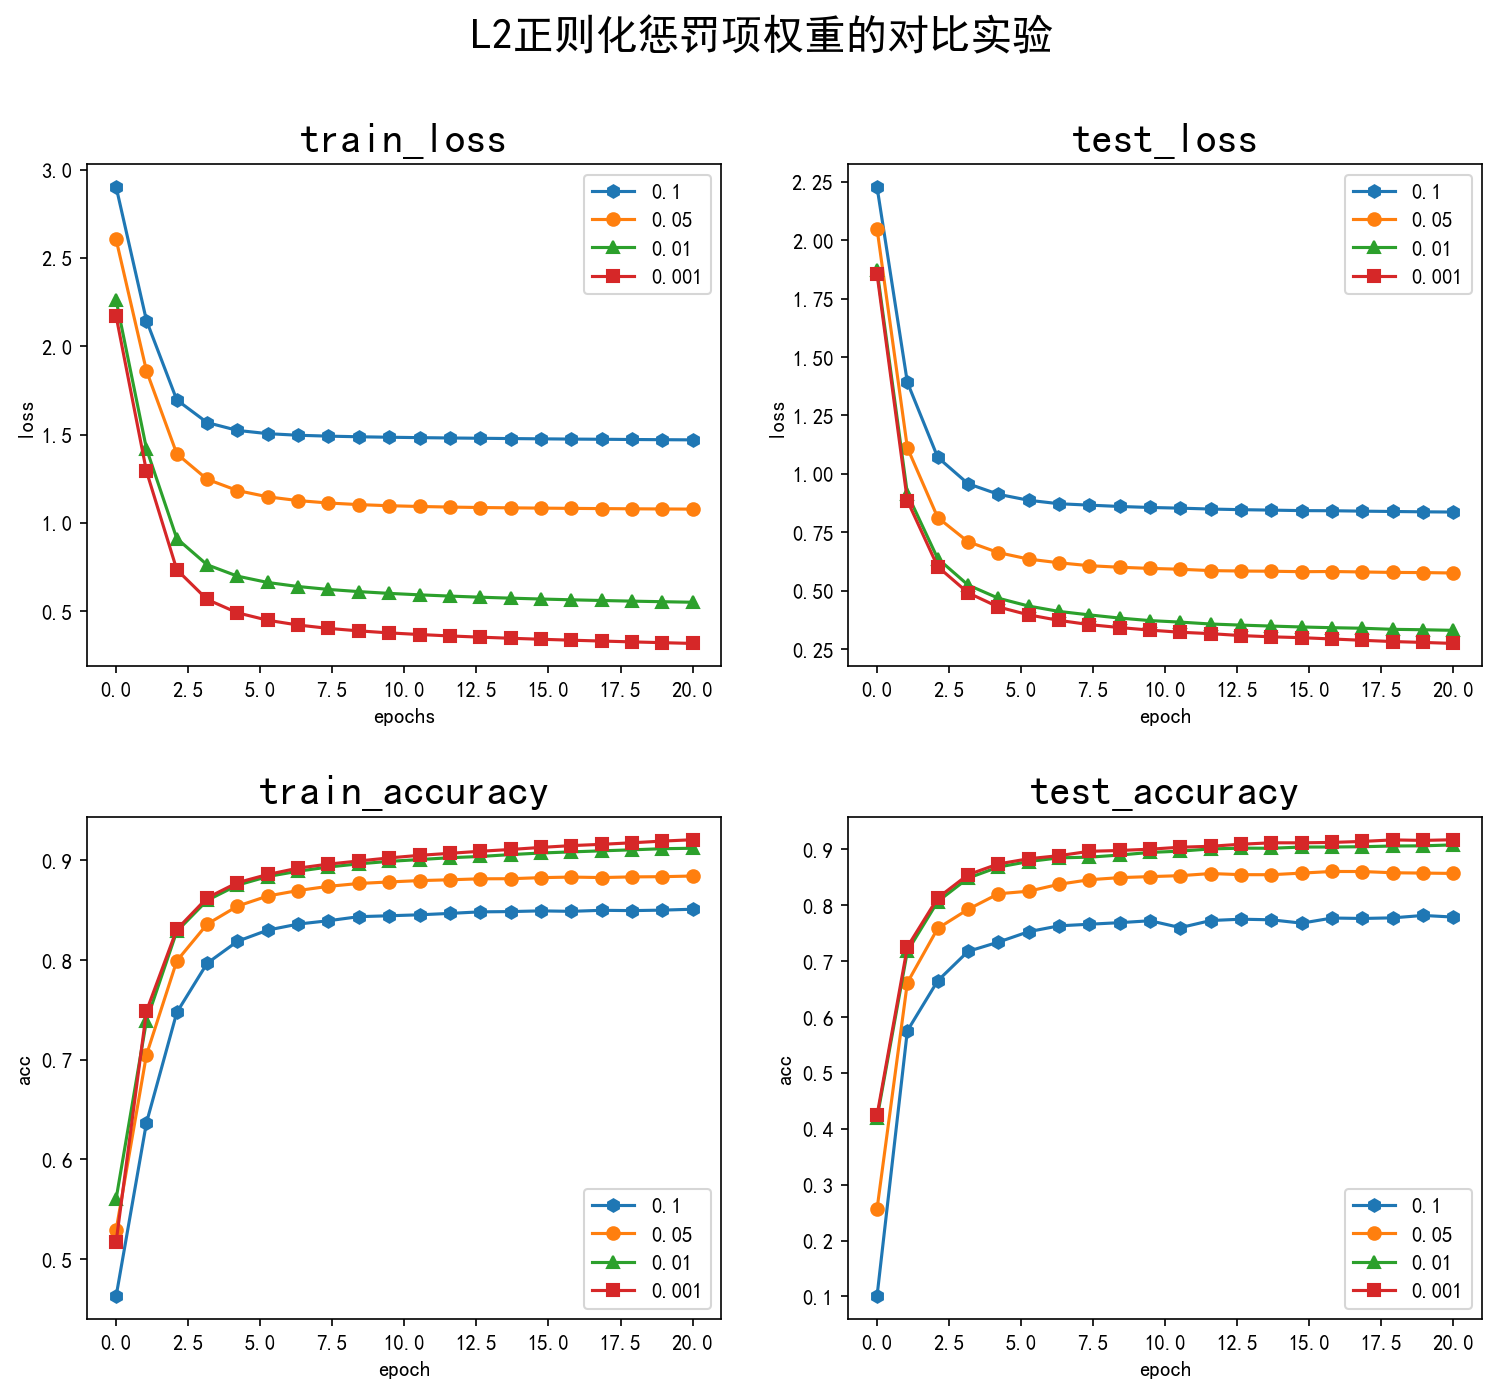

In [ ]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("L2正则化惩罚项权重的对比实验", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_loss_list_L2Norm1), len(train_loss_list_L2Norm1))
ax1.plot(x, train_loss_list_L2Norm1, label="0.1", marker="h", linewidth=1.5)
ax1.plot(x, train_loss_list_L2Norm2, label="0.05", marker="o", linewidth=1.5)
ax1.plot(x, train_loss_list_L2Norm3, label="0.01", marker="^", linewidth=1.5)
ax1.plot(x, train_loss_list_L2Norm4, label="0.001", marker="s", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_loss_list_L2Norm1, label="0.1", marker="h", linewidth=1.5)
ax2.plot(x, test_loss_list_L2Norm2, label="0.05", marker="o", linewidth=1.5)
ax2.plot(x, test_loss_list_L2Norm3, label="0.01", marker="^", linewidth=1.5)
ax2.plot(x, test_loss_list_L2Norm4, label="0.001", marker="s", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_list_L2Norm1, label="0.1", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_list_L2Norm2, label="0.05", marker="o", linewidth=1.5)
ax3.plot(x, train_acc_list_L2Norm3, label="0.01", marker="^", linewidth=1.5)
ax3.plot(x, train_acc_list_L2Norm4, label="0.001", marker="s", linewidth=1.5)

# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_list_L2Norm1, label="0.1", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_list_L2Norm2, label="0.05", marker="o", linewidth=1.5)
ax4.plot(x, test_acc_list_L2Norm3, label="0.01", marker="^", linewidth=1.5)
ax4.plot(x, test_acc_list_L2Norm4, label="0.001", marker="s", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

#### 结论
越小的惩罚权重，训练集和测试集上的loss值越小，分类的准确率越大

## 1.4 手动实现dropout，进行不同丢弃率的对比实验

In [9]:
# 重新定义评价函数
def evaluate_accuracy_drop(data_iter, loss_func):
    acc_sum, test_l_sum, n, c = 0.0, 0.0, 0.0, 0.0
    model = FeedForwardNN_Drop(is_training=False)
    for X, y in data_iter:
        result = model.forward(X)
        result = torch.round(result)
        acc_sum += (result.argmax(dim=1) == y).sum().item()
        test_l_sum += loss_func(result, y.flatten().long()).item()
        n += y.shape[0]
        c += 1
    return acc_sum / n, test_l_sum / c

In [10]:
# 定义dropout函数
def dropout(X, drop_prob):
    X = X.float()
    # 丢弃概率是否在0到1之间
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 全部丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    # 生成mask矩阵（向量）
    mask = (torch.rand(X.shape) < keep_prob).float()
    # 按照mask进行对X进行变换
    return mask * X / keep_prob


# 定义模型
class FeedForwardNN_Drop:
    def __init__(self, is_training=True, dropout_prob=0.1):
        # 定义并初始化模型参数
        num_input, num_output, num_hiddens = 784, 10, 256
        W1 = torch.tensor(
            np.random.normal(0, 0.01, size=(num_hiddens, num_input)),
            dtype=torch.float32,
        )
        b1 = torch.zeros(num_hiddens, dtype=torch.float32)
        W2 = torch.tensor(
            np.random.normal(0, 0.01, size=(num_output, num_hiddens)),
            dtype=torch.float32,
        )
        b2 = torch.zeros(num_output, dtype=torch.float32)
        self.params = [W1, b1, W2, b2]
        self.training = is_training
        self.dropout_prob = dropout_prob
        for param in self.params:
            param.requires_grad = True

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_ReLU(torch.matmul(x, W1.T) + b1)
        self.output_layer = lambda x: torch.matmul(x, W2.T) + b2

    @staticmethod
    def my_ReLU(x):
        return torch.max(input=x, other=torch.tensor(0.0))

    def forward(self, x):
        # 定义模型前向传播过程
        flatten_input = self.input_layer(x)
        hidden_output = self.hidden_layer(flatten_input)
        if self.training == True:
            # 在隐藏层后添加dropout层
            hidden_output = dropout(hidden_output, self.dropout_prob)
        final_output = self.output_layer(hidden_output)
        return final_output


# 定义训练函数
def train_drop(model, train_loader, test_loader, loss, optimizer, num_epochs, lr=None):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    start = time.time()
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            # 前向传播
            y_hat = model.forward(X)
            # 计算损失
            l = loss(y_hat, y.flatten().long()).sum()
            # 反向传播
            l.backward()
            # 参数优化
            optimizer(model.params, lr)
            # 梯度清零
            for param in model.params:
                param.grad.data.zero_()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]

        test_acc, test_loss_sum = evaluate_accuracy_drop(test_loader, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)

        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

### 1.4.1 dropout_prob=0.1

In [11]:
# 定义超参数、损失函数、优化器
num_epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()
optimizer = SGD

In [12]:
model = FeedForwardNN_Drop()
train_loss_list_D1, test_loss_list_D1, train_acc_list_D1, test_acc_list_D1 = train_drop(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 2.1472,test_loss 2.3026 train acc 0.563 test acc 0.098
epoch 2, train_loss 1.2514,test_loss 2.3026 train acc 0.742 test acc 0.098
epoch 3, train_loss 0.7234,test_loss 2.3026 train acc 0.824 test acc 0.098
epoch 4, train_loss 0.5570,test_loss 2.3026 train acc 0.854 test acc 0.098
epoch 5, train_loss 0.4800,test_loss 2.3026 train acc 0.871 test acc 0.098
epoch 6, train_loss 0.4363,test_loss 2.3026 train acc 0.880 test acc 0.098
epoch 7, train_loss 0.4059,test_loss 2.3026 train acc 0.888 test acc 0.098
epoch 8, train_loss 0.3852,test_loss 2.3026 train acc 0.893 test acc 0.098
epoch 9, train_loss 0.3679,test_loss 2.3026 train acc 0.897 test acc 0.098
epoch 10, train_loss 0.3555,test_loss 2.3026 train acc 0.900 test acc 0.098
epoch 11, train_loss 0.3441,test_loss 2.3026 train acc 0.902 test acc 0.098
epoch 12, train_loss 0.3322,test_loss 2.3026 train acc 0.906 test acc 0.098
epoch 13, train_loss 0.3248,test_loss 2.3026 train acc 0.907 test acc 0.098
epoch 14, train_loss 

### 1.4.2 dropout_prob=0.3

In [41]:
model = FeedForwardNN_Drop(dropout_prob=0.3)
train_loss_list_D3, test_loss_list_D3, train_acc_list_D3, test_acc_list_D3 = train_drop(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 2.1758,test_loss 2.3026 train acc 0.531 test acc 0.098
epoch 2, train_loss 1.3325,test_loss 2.3026 train acc 0.713 test acc 0.098
epoch 3, train_loss 0.7779,test_loss 2.3026 train acc 0.803 test acc 0.098
epoch 4, train_loss 0.6012,test_loss 2.3026 train acc 0.836 test acc 0.098
epoch 5, train_loss 0.5181,test_loss 2.3026 train acc 0.857 test acc 0.098
epoch 6, train_loss 0.4693,test_loss 2.3026 train acc 0.869 test acc 0.098
epoch 7, train_loss 0.4358,test_loss 2.3026 train acc 0.877 test acc 0.098
epoch 8, train_loss 0.4104,test_loss 2.3026 train acc 0.885 test acc 0.098
epoch 9, train_loss 0.3904,test_loss 2.3026 train acc 0.890 test acc 0.098
epoch 10, train_loss 0.3765,test_loss 2.3026 train acc 0.894 test acc 0.098
epoch 11, train_loss 0.3619,test_loss 2.3026 train acc 0.897 test acc 0.098
epoch 12, train_loss 0.3507,test_loss 2.3026 train acc 0.900 test acc 0.098
epoch 13, train_loss 0.3391,test_loss 2.3026 train acc 0.903 test acc 0.098
epoch 14, train_loss 

### 1.4.3 dropout_prob=0.5

In [42]:
model = FeedForwardNN_Drop(dropout_prob=0.5)
train_loss_list_D5, test_loss_list_D5, train_acc_list_D5, test_acc_list_D5 = train_drop(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 2.1552,test_loss 2.3026 train acc 0.473 test acc 0.098
epoch 2, train_loss 1.3181,test_loss 2.3026 train acc 0.707 test acc 0.098
epoch 3, train_loss 0.8069,test_loss 2.3026 train acc 0.786 test acc 0.098
epoch 4, train_loss 0.6353,test_loss 2.3026 train acc 0.824 test acc 0.098
epoch 5, train_loss 0.5539,test_loss 2.3026 train acc 0.846 test acc 0.098
epoch 6, train_loss 0.5015,test_loss 2.3026 train acc 0.858 test acc 0.098
epoch 7, train_loss 0.4651,test_loss 2.3026 train acc 0.869 test acc 0.098
epoch 8, train_loss 0.4390,test_loss 2.3026 train acc 0.876 test acc 0.098
epoch 9, train_loss 0.4177,test_loss 2.3026 train acc 0.881 test acc 0.098
epoch 10, train_loss 0.3998,test_loss 2.3026 train acc 0.887 test acc 0.098
epoch 11, train_loss 0.3858,test_loss 2.3026 train acc 0.889 test acc 0.098
epoch 12, train_loss 0.3720,test_loss 2.3026 train acc 0.894 test acc 0.098
epoch 13, train_loss 0.3620,test_loss 2.3026 train acc 0.897 test acc 0.098
epoch 14, train_loss 

### 1.4.4 三种丢弃率的实验结果对比

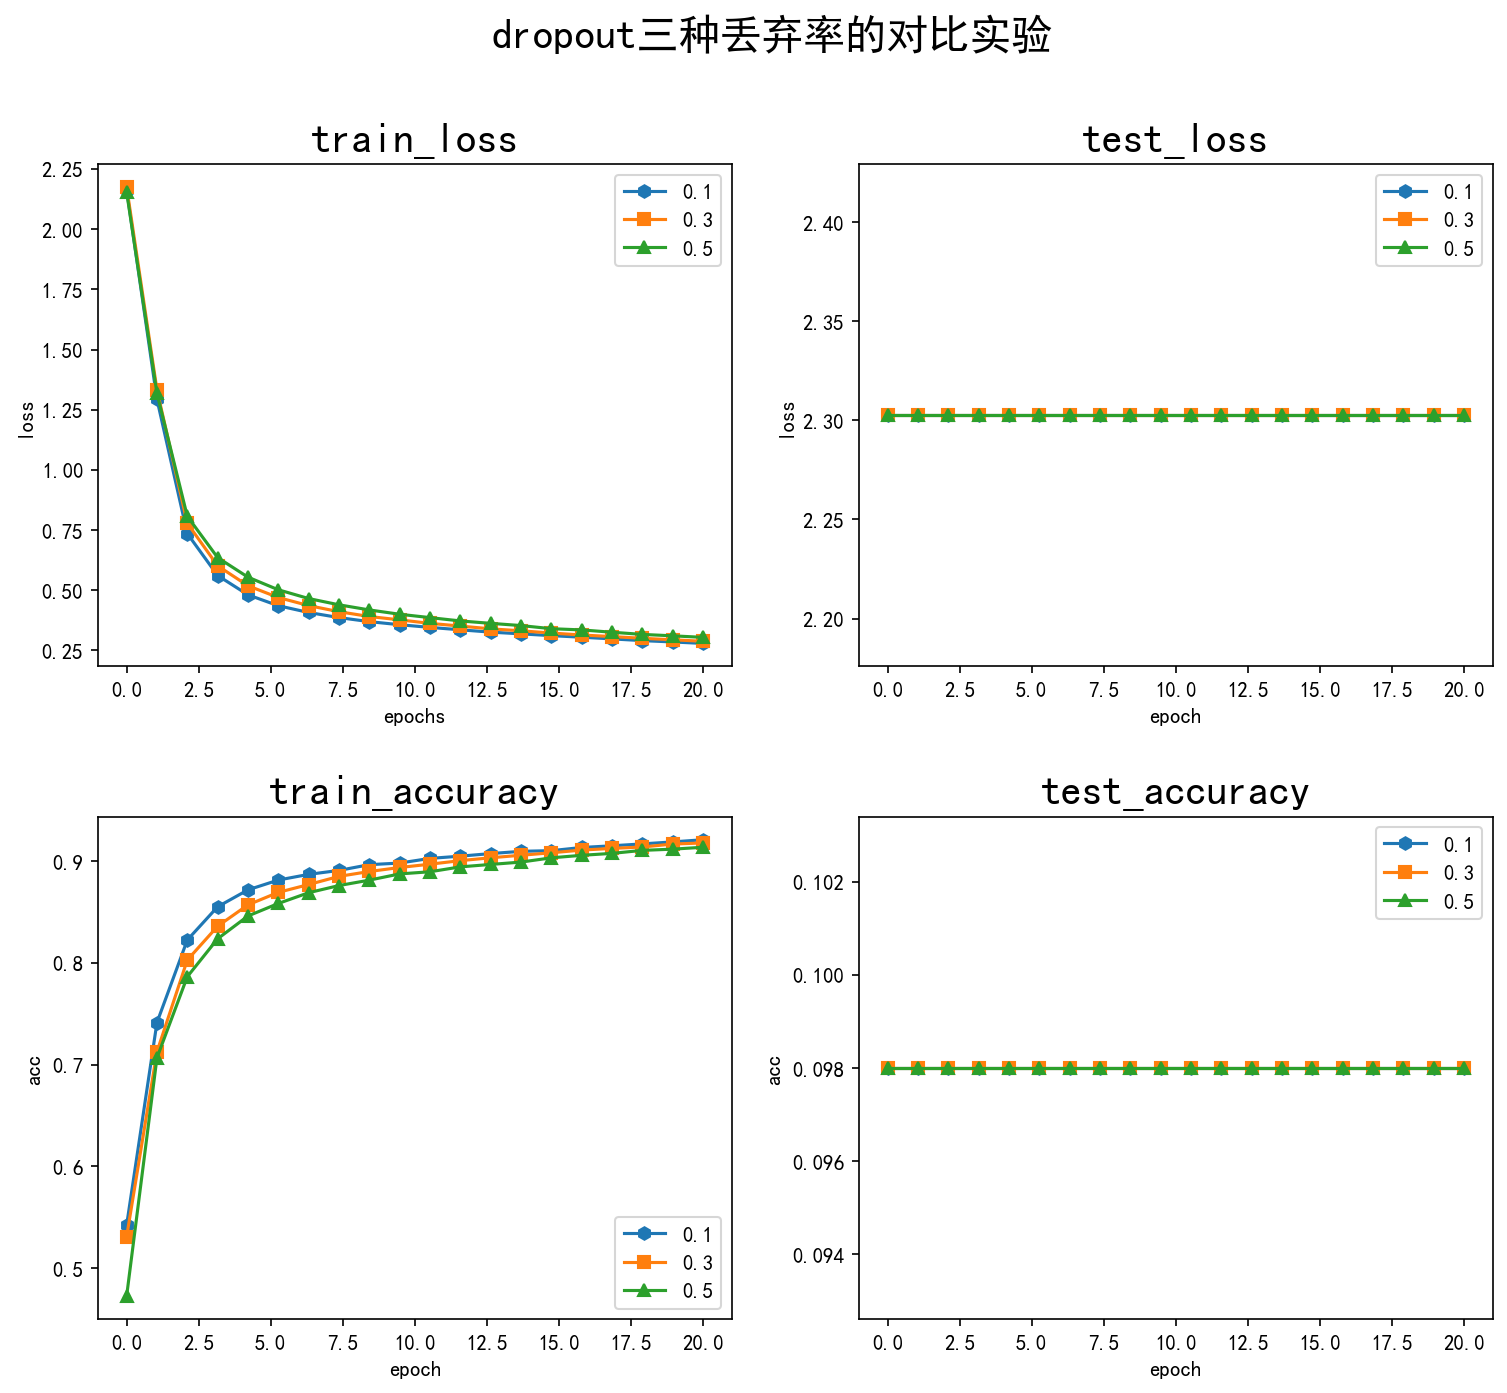

In [52]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("dropout三种丢弃率的对比实验", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_loss_list_D1), len(train_loss_list_D1))
ax1.plot(x, train_loss_list_D1, label="0.1", marker="h", linewidth=1.5)
ax1.plot(x, train_loss_list_D3, label="0.3", marker="s", linewidth=1.5)
ax1.plot(x, train_loss_list_D5, label="0.5", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_loss_list_D1, label="0.1", marker="h", linewidth=1.5)
ax2.plot(x, test_loss_list_D3, label="0.3", marker="s", linewidth=1.5)
ax2.plot(x, test_loss_list_D5, label="0.5", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_list_D1, label="0.1", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_list_D3, label="0.3", marker="s", linewidth=1.5)
ax3.plot(x, train_acc_list_D5, label="0.5", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_list_D1, label="0.1", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_list_D3, label="0.3", marker="s", linewidth=1.5)
ax4.plot(x, test_acc_list_D5, label="0.5", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

#### 结论：
可以发现随着丢弃率的增大，模型训练的损失值越来越大，训练集的预测精确率越来越低，因此较小的丢弃率的分类效果会更好
#### 问题：
这里的测试损失和测试精确率计算有问题，这两项指标都是通过函数evaluate_accuracy_drop()来计算的，但是找不出这个函数的问题，先进行基于torch.nn实现的任务吧

# 2. 多分类任务：基于PyTorch实现部分

## 2.1 基于PyTorch构建前馈神经网络

In [18]:
"""
基于PyTorch构造前馈神经网络，采用三种不同的激活函数
网络结构：一层隐藏层、 输入维度784、隐藏层维度256、输出维度10
"""


# Relu激活函数
class FeedForwardNN_Relu(nn.Module):
    def __init__(self):
        super(FeedForwardNN_Relu, self).__init__()
        input_size, hidden_size, num_classes = 784, 256, 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        relu = nn.ReLU()
        out = relu(self.layer1(x.view(x.shape[0], -1)))  # 需将输入层展平
        out = self.layer2(out)
        return out


# Sigmoid激活函数
class FeedForwardNN_Sig(nn.Module):
    def __init__(self):
        super(FeedForwardNN_Sig, self).__init__()
        input_size, hidden_size, num_classes = 784, 256, 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.layer1(x.view(x.shape[0], -1)))
        out = self.layer2(out)
        return out


# Leaky-Relu激活函数
class FeedForwardNN_LeakyRelu(nn.Module):
    def __init__(self):
        super(FeedForwardNN_LeakyRelu, self).__init__()
        input_size, hidden_size, num_classes = 784, 256, 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # 设置负斜率为0.01
        out = leaky_relu(self.layer1(x.view(x.shape[0], -1)))
        out = self.layer2(out)
        return out


# 定义训练函数
def train(model, train_loader, test_loader, loss, optimizer, num_epochs):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0

        for X, y in train_loader:
            # 前向传播
            y_hat = model(X.view(-1, 784))
            # 计算损失
            l = loss(y_hat, y.flatten().long()).sum()
            # 反向传播
            l.backward()
            # 参数优化更新
            optimizer.step()
            # 梯度清零
            optimizer.zero_grad()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]

        # 计算每轮epoch的损失和准确率
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)

        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

## 2.2 三种激活函数的对比实验

### 2.2.1Relu激活函数

In [30]:
num_epochs = 20
lr = 0.01

model = FeedForwardNN_Relu()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

train_losses_relu, test_losses_relu, train_acc_relu, test_acc_relu = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 0.2101,test_loss 0.1231 train acc 0.936 test acc 0.964
epoch 2, train_loss 0.1086,test_loss 0.1242 train acc 0.967 test acc 0.963
epoch 3, train_loss 0.0861,test_loss 0.1145 train acc 0.974 test acc 0.968
epoch 4, train_loss 0.0793,test_loss 0.1259 train acc 0.977 test acc 0.967
epoch 5, train_loss 0.0694,test_loss 0.1711 train acc 0.980 test acc 0.964
epoch 6, train_loss 0.0625,test_loss 0.1350 train acc 0.982 test acc 0.970
epoch 7, train_loss 0.0570,test_loss 0.1333 train acc 0.984 test acc 0.970
epoch 8, train_loss 0.0649,test_loss 0.1411 train acc 0.983 test acc 0.973
epoch 9, train_loss 0.0497,test_loss 0.1498 train acc 0.986 test acc 0.973
epoch 10, train_loss 0.0418,test_loss 0.1620 train acc 0.988 test acc 0.974
epoch 11, train_loss 0.0527,test_loss 0.1876 train acc 0.987 test acc 0.970
epoch 12, train_loss 0.0470,test_loss 0.1712 train acc 0.988 test acc 0.973
epoch 13, train_loss 0.0501,test_loss 0.2502 train acc 0.988 test acc 0.968
epoch 14, train_loss 

### 2.2.2 sigmoid激活函数

In [31]:
num_epochs = 20
lr = 0.01

model = FeedForwardNN_Sig()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

train_losses_sigmoid, test_losses_sigmoid, train_acc_sigmoid, test_acc_sigmoid = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 0.2661,test_loss 0.1351 train acc 0.919 test acc 0.955
epoch 2, train_loss 0.0979,test_loss 0.0949 train acc 0.970 test acc 0.972
epoch 3, train_loss 0.0658,test_loss 0.0997 train acc 0.979 test acc 0.966
epoch 4, train_loss 0.0495,test_loss 0.0835 train acc 0.984 test acc 0.974
epoch 5, train_loss 0.0398,test_loss 0.0748 train acc 0.987 test acc 0.977
epoch 6, train_loss 0.0320,test_loss 0.0747 train acc 0.990 test acc 0.976
epoch 7, train_loss 0.0273,test_loss 0.0861 train acc 0.991 test acc 0.975
epoch 8, train_loss 0.0276,test_loss 0.0944 train acc 0.991 test acc 0.972
epoch 9, train_loss 0.0248,test_loss 0.1103 train acc 0.992 test acc 0.970
epoch 10, train_loss 0.0263,test_loss 0.0918 train acc 0.991 test acc 0.975
epoch 11, train_loss 0.0231,test_loss 0.1024 train acc 0.992 test acc 0.974
epoch 12, train_loss 0.0226,test_loss 0.1009 train acc 0.992 test acc 0.973
epoch 13, train_loss 0.0219,test_loss 0.1014 train acc 0.992 test acc 0.975
epoch 14, train_loss 

### 2.2.3 Leaky-Relu激活函数

In [32]:
num_epochs = 20
lr = 0.01

model = FeedForwardNN_LeakyRelu()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

(
    train_losses_leakyrelu,
    test_losses_leakyrelu,
    train_acc_leakyrelu,
    test_acc_leakyrelu,
) = train(model, train_loader, test_loader, loss, optimizer, num_epochs, lr)

epoch 1, train_loss 0.2084,test_loss 0.1327 train acc 0.937 test acc 0.960
epoch 2, train_loss 0.1056,test_loss 0.0939 train acc 0.968 test acc 0.970
epoch 3, train_loss 0.0863,test_loss 0.1327 train acc 0.975 test acc 0.964
epoch 4, train_loss 0.0818,test_loss 0.1251 train acc 0.977 test acc 0.968
epoch 5, train_loss 0.0664,test_loss 0.1452 train acc 0.981 test acc 0.964
epoch 6, train_loss 0.0637,test_loss 0.1678 train acc 0.983 test acc 0.960
epoch 7, train_loss 0.0590,test_loss 0.1684 train acc 0.984 test acc 0.967
epoch 8, train_loss 0.0630,test_loss 0.1584 train acc 0.984 test acc 0.970
epoch 9, train_loss 0.0563,test_loss 0.1848 train acc 0.986 test acc 0.969
epoch 10, train_loss 0.0545,test_loss 0.1765 train acc 0.986 test acc 0.971
epoch 11, train_loss 0.0488,test_loss 0.2038 train acc 0.989 test acc 0.972
epoch 12, train_loss 0.0562,test_loss 0.1930 train acc 0.987 test acc 0.972
epoch 13, train_loss 0.0474,test_loss 0.2232 train acc 0.989 test acc 0.973
epoch 14, train_loss 

### 2.2.4 三种激活函数实验结果对比

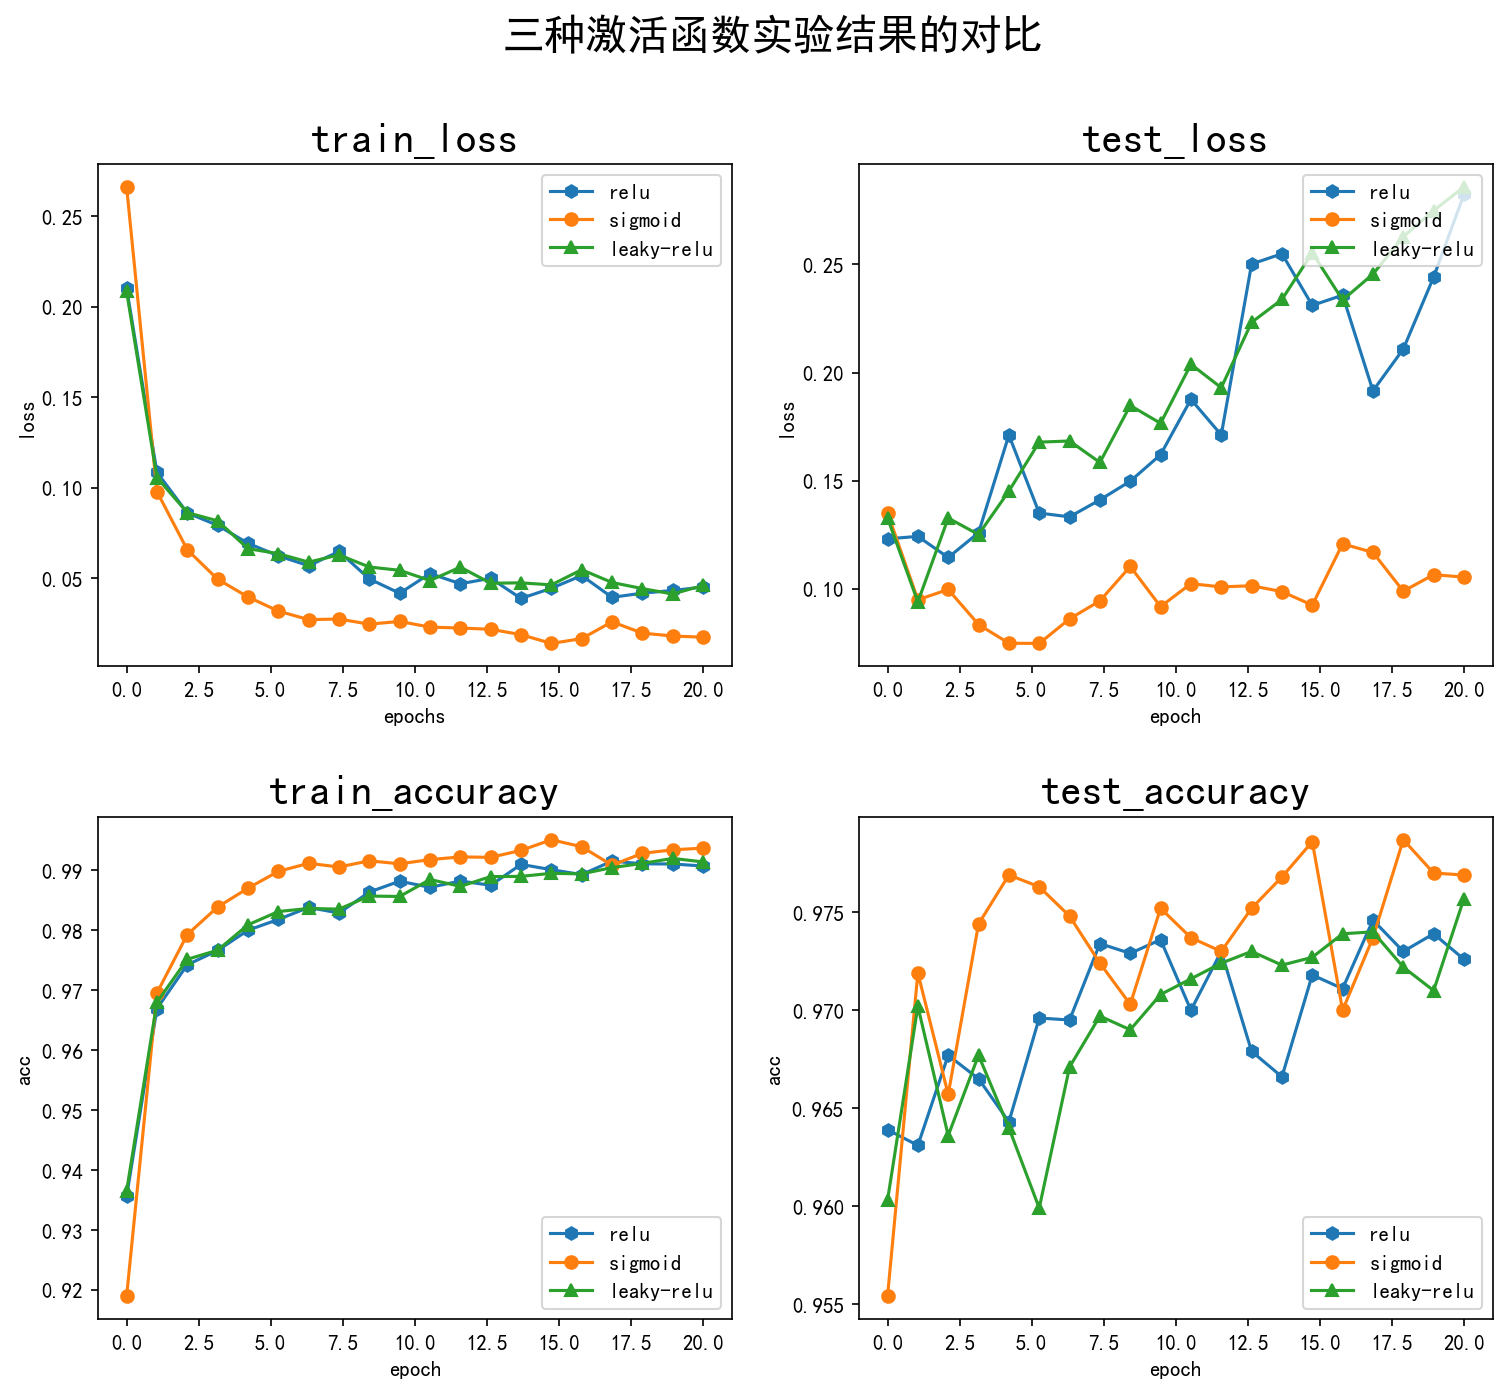

In [33]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("三种激活函数实验结果的对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses_relu), len(train_losses_relu))
ax1.plot(x, train_losses_relu, label="relu", marker="h", linewidth=1.5)
ax1.plot(x, train_losses_sigmoid, label="sigmoid", marker="o", linewidth=1.5)
ax1.plot(x, train_losses_leakyrelu, label="leaky-relu", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses_relu, label="relu", marker="h", linewidth=1.5)
ax2.plot(x, test_losses_sigmoid, label="sigmoid", marker="o", linewidth=1.5)
ax2.plot(x, test_losses_leakyrelu, label="leaky-relu", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_relu, label="relu", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_sigmoid, label="sigmoid", marker="o", linewidth=1.5)
ax3.plot(x, train_acc_leakyrelu, label="leaky-relu", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_relu, label="relu", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_sigmoid, label="sigmoid", marker="o", linewidth=1.5)
ax4.plot(x, test_acc_leakyrelu, label="leaky-relu", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

## 2.3 隐藏层层数、隐藏单元个数的对比实验

In [19]:
num_epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()

### 2.3.1 隐藏层数：1

In [20]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_dim):
        super(FeedForwardNN, self).__init__()
        input_dim, output_dim = 784, 10
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x.view(x.shape[0], -1))
        x = self.relu1(x)
        x = self.fc2(x)
        return x


In [21]:
model = FeedForwardNN(hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses1, test_losses1, train_acc1, test_acc1 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 0.2119,test_loss 0.1169 train acc 0.936 test acc 0.963
epoch 2, train_loss 0.1087,test_loss 0.1070 train acc 0.968 test acc 0.968
epoch 3, train_loss 0.0810,test_loss 0.1047 train acc 0.975 test acc 0.971
epoch 4, train_loss 0.0758,test_loss 0.1259 train acc 0.977 test acc 0.970
epoch 5, train_loss 0.0731,test_loss 0.1574 train acc 0.979 test acc 0.959
epoch 6, train_loss 0.0682,test_loss 0.1581 train acc 0.981 test acc 0.967
epoch 7, train_loss 0.0605,test_loss 0.1640 train acc 0.984 test acc 0.966
epoch 8, train_loss 0.0503,test_loss 0.1611 train acc 0.986 test acc 0.969
epoch 9, train_loss 0.0525,test_loss 0.1573 train acc 0.986 test acc 0.972
epoch 10, train_loss 0.0507,test_loss 0.1745 train acc 0.987 test acc 0.970
epoch 11, train_loss 0.0424,test_loss 0.1715 train acc 0.989 test acc 0.975
epoch 12, train_loss 0.0426,test_loss 0.2196 train acc 0.989 test acc 0.971
epoch 13, train_loss 0.0483,test_loss 0.2101 train acc 0.988 test acc 0.974
epoch 14, train_loss 

### 2.3.2 隐藏层数：2

In [22]:
class ThreeLayerFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ThreeLayerFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# 两层隐藏层
input_size = 784
hidden_size1 = 256
hidden_size2 = 128
output_size = 10

model = ThreeLayerFeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses2, test_losses2, train_acc2, test_acc2 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 1.6702,test_loss 1.6270 train acc 0.791 test acc 0.833
epoch 2, train_loss 1.6058,test_loss 1.5741 train acc 0.855 test acc 0.886
epoch 3, train_loss 1.5954,test_loss 1.7017 train acc 0.866 test acc 0.761
epoch 4, train_loss 1.5904,test_loss 1.5616 train acc 0.871 test acc 0.899
epoch 5, train_loss 1.5775,test_loss 1.5788 train acc 0.884 test acc 0.882
epoch 6, train_loss 1.5940,test_loss 1.5837 train acc 0.867 test acc 0.877
epoch 7, train_loss 1.5954,test_loss 1.5726 train acc 0.866 test acc 0.888
epoch 8, train_loss 1.5975,test_loss 1.5928 train acc 0.864 test acc 0.868
epoch 9, train_loss 1.5834,test_loss 1.5834 train acc 0.878 test acc 0.877
epoch 10, train_loss 1.6186,test_loss 1.7480 train acc 0.843 test acc 0.711
epoch 11, train_loss 1.6479,test_loss 1.6737 train acc 0.813 test acc 0.787
epoch 12, train_loss 1.6535,test_loss 1.5984 train acc 0.808 test acc 0.863
epoch 13, train_loss 1.6025,test_loss 1.6239 train acc 0.859 test acc 0.836
epoch 14, train_loss 

### 2.3.3 隐藏层数：3

In [23]:
class ThreeLayerFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(ThreeLayerFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x)

input_size = 784
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 10

model = ThreeLayerFeedForwardNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses3, test_losses3, train_acc3, test_acc3 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 1.6722,test_loss 1.6087 train acc 0.789 test acc 0.852
epoch 2, train_loss 1.6489,test_loss 1.8393 train acc 0.812 test acc 0.623
epoch 3, train_loss 1.7042,test_loss 1.6517 train acc 0.757 test acc 0.809
epoch 4, train_loss 1.7446,test_loss 1.7786 train acc 0.717 test acc 0.684
epoch 5, train_loss 1.6954,test_loss 1.6965 train acc 0.766 test acc 0.763
epoch 6, train_loss 1.7639,test_loss 1.6349 train acc 0.697 test acc 0.824
epoch 7, train_loss 1.7470,test_loss 1.7423 train acc 0.714 test acc 0.719
epoch 8, train_loss 1.9133,test_loss 1.9158 train acc 0.548 test acc 0.547
epoch 9, train_loss 1.8856,test_loss 1.7782 train acc 0.576 test acc 0.685
epoch 10, train_loss 1.7537,test_loss 1.7893 train acc 0.707 test acc 0.672
epoch 11, train_loss 1.7843,test_loss 1.8338 train acc 0.677 test acc 0.627
epoch 12, train_loss 1.8289,test_loss 1.8152 train acc 0.632 test acc 0.645
epoch 13, train_loss 1.9391,test_loss 1.9414 train acc 0.522 test acc 0.521
epoch 14, train_loss 

### 隐藏层数的实验结果对比

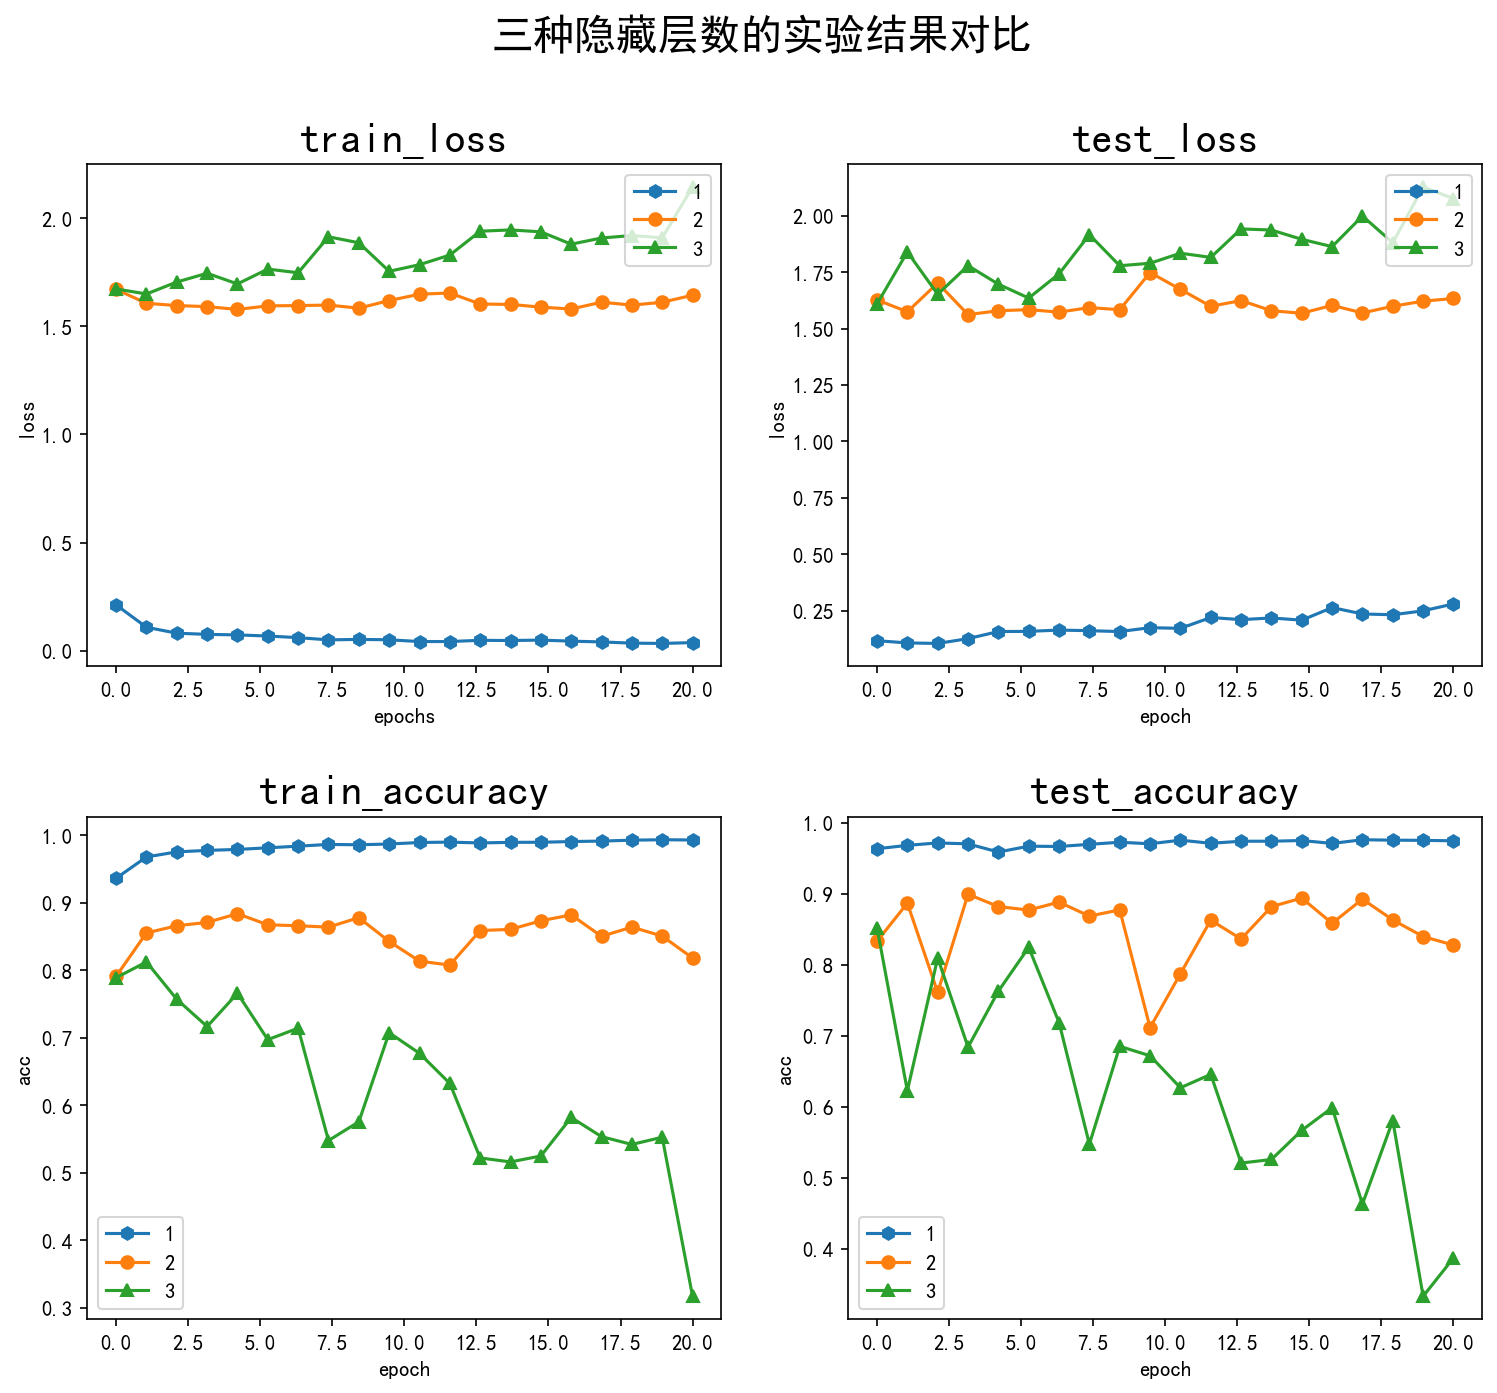

In [27]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("三种隐藏层数的实验结果对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses4), len(train_losses4))
ax1.plot(x, train_losses1, label="1", marker="h", linewidth=1.5)
ax1.plot(x, train_losses2, label="2", marker="o", linewidth=1.5)
ax1.plot(x, train_losses3, label="3", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses1, label="1", marker="h", linewidth=1.5)
ax2.plot(x, test_losses2, label="2", marker="o", linewidth=1.5)
ax2.plot(x, test_losses3, label="3", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc1, label="1", marker="h", linewidth=1.5)
ax3.plot(x, train_acc2, label="2", marker="o", linewidth=1.5)
ax3.plot(x, train_acc3, label="3", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc1, label="1", marker="h", linewidth=1.5)
ax4.plot(x, test_acc2, label="2", marker="o", linewidth=1.5)
ax4.plot(x, test_acc3, label="3", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

#### 结论
3层隐藏层很明显过拟合了

### 2.3.3 隐藏单元数：128

In [24]:
model = FeedForwardNN(hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses4, test_losses4, train_acc4, test_acc4 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 0.2220,test_loss 0.1293 train acc 0.932 test acc 0.960
epoch 2, train_loss 0.1147,test_loss 0.1077 train acc 0.965 test acc 0.968
epoch 3, train_loss 0.0861,test_loss 0.1102 train acc 0.974 test acc 0.968
epoch 4, train_loss 0.0784,test_loss 0.1245 train acc 0.976 test acc 0.969
epoch 5, train_loss 0.0759,test_loss 0.1236 train acc 0.977 test acc 0.972
epoch 6, train_loss 0.0623,test_loss 0.1260 train acc 0.981 test acc 0.970
epoch 7, train_loss 0.0562,test_loss 0.1565 train acc 0.983 test acc 0.967
epoch 8, train_loss 0.0550,test_loss 0.1598 train acc 0.984 test acc 0.971
epoch 9, train_loss 0.0564,test_loss 0.1739 train acc 0.984 test acc 0.970
epoch 10, train_loss 0.0591,test_loss 0.1666 train acc 0.984 test acc 0.972
epoch 11, train_loss 0.0455,test_loss 0.1509 train acc 0.988 test acc 0.974
epoch 12, train_loss 0.0408,test_loss 0.1681 train acc 0.989 test acc 0.973
epoch 13, train_loss 0.0463,test_loss 0.2188 train acc 0.988 test acc 0.970
epoch 14, train_loss 

### 2.3.4 隐藏单元数：256

In [25]:
model = FeedForwardNN(hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses5, test_losses5, train_acc5, test_acc5 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 0.2103,test_loss 0.1261 train acc 0.936 test acc 0.960
epoch 2, train_loss 0.1070,test_loss 0.1351 train acc 0.968 test acc 0.959
epoch 3, train_loss 0.0842,test_loss 0.1069 train acc 0.975 test acc 0.974
epoch 4, train_loss 0.0779,test_loss 0.1821 train acc 0.977 test acc 0.954
epoch 5, train_loss 0.0681,test_loss 0.1473 train acc 0.980 test acc 0.968
epoch 6, train_loss 0.0617,test_loss 0.1248 train acc 0.982 test acc 0.971
epoch 7, train_loss 0.0566,test_loss 0.1462 train acc 0.984 test acc 0.972
epoch 8, train_loss 0.0571,test_loss 0.1504 train acc 0.984 test acc 0.973
epoch 9, train_loss 0.0559,test_loss 0.1954 train acc 0.986 test acc 0.966
epoch 10, train_loss 0.0502,test_loss 0.2022 train acc 0.988 test acc 0.967
epoch 11, train_loss 0.0480,test_loss 0.1911 train acc 0.988 test acc 0.970
epoch 12, train_loss 0.0425,test_loss 0.2192 train acc 0.989 test acc 0.968
epoch 13, train_loss 0.0459,test_loss 0.2098 train acc 0.989 test acc 0.972
epoch 14, train_loss 

### 2.3.5 隐藏单元数：512

In [26]:
model = FeedForwardNN(hidden_dim=512)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses6, test_losses6, train_acc6, test_acc6 = train(model, train_loader, test_loader, loss, optimizer, num_epochs)

epoch 1, train_loss 0.2156,test_loss 0.1249 train acc 0.934 test acc 0.959
epoch 2, train_loss 0.1103,test_loss 0.1073 train acc 0.967 test acc 0.968
epoch 3, train_loss 0.0876,test_loss 0.1334 train acc 0.974 test acc 0.964
epoch 4, train_loss 0.0741,test_loss 0.1040 train acc 0.978 test acc 0.973
epoch 5, train_loss 0.0645,test_loss 0.1357 train acc 0.981 test acc 0.969
epoch 6, train_loss 0.0651,test_loss 0.1348 train acc 0.982 test acc 0.969
epoch 7, train_loss 0.0613,test_loss 0.1459 train acc 0.984 test acc 0.973
epoch 8, train_loss 0.0511,test_loss 0.1484 train acc 0.986 test acc 0.973
epoch 9, train_loss 0.0467,test_loss 0.1484 train acc 0.987 test acc 0.974
epoch 10, train_loss 0.0469,test_loss 0.1649 train acc 0.988 test acc 0.976
epoch 11, train_loss 0.0520,test_loss 0.1605 train acc 0.988 test acc 0.975
epoch 12, train_loss 0.0503,test_loss 0.1895 train acc 0.988 test acc 0.975
epoch 13, train_loss 0.0463,test_loss 0.2107 train acc 0.990 test acc 0.974
epoch 14, train_loss 

### 隐藏单元数的实验结果对比

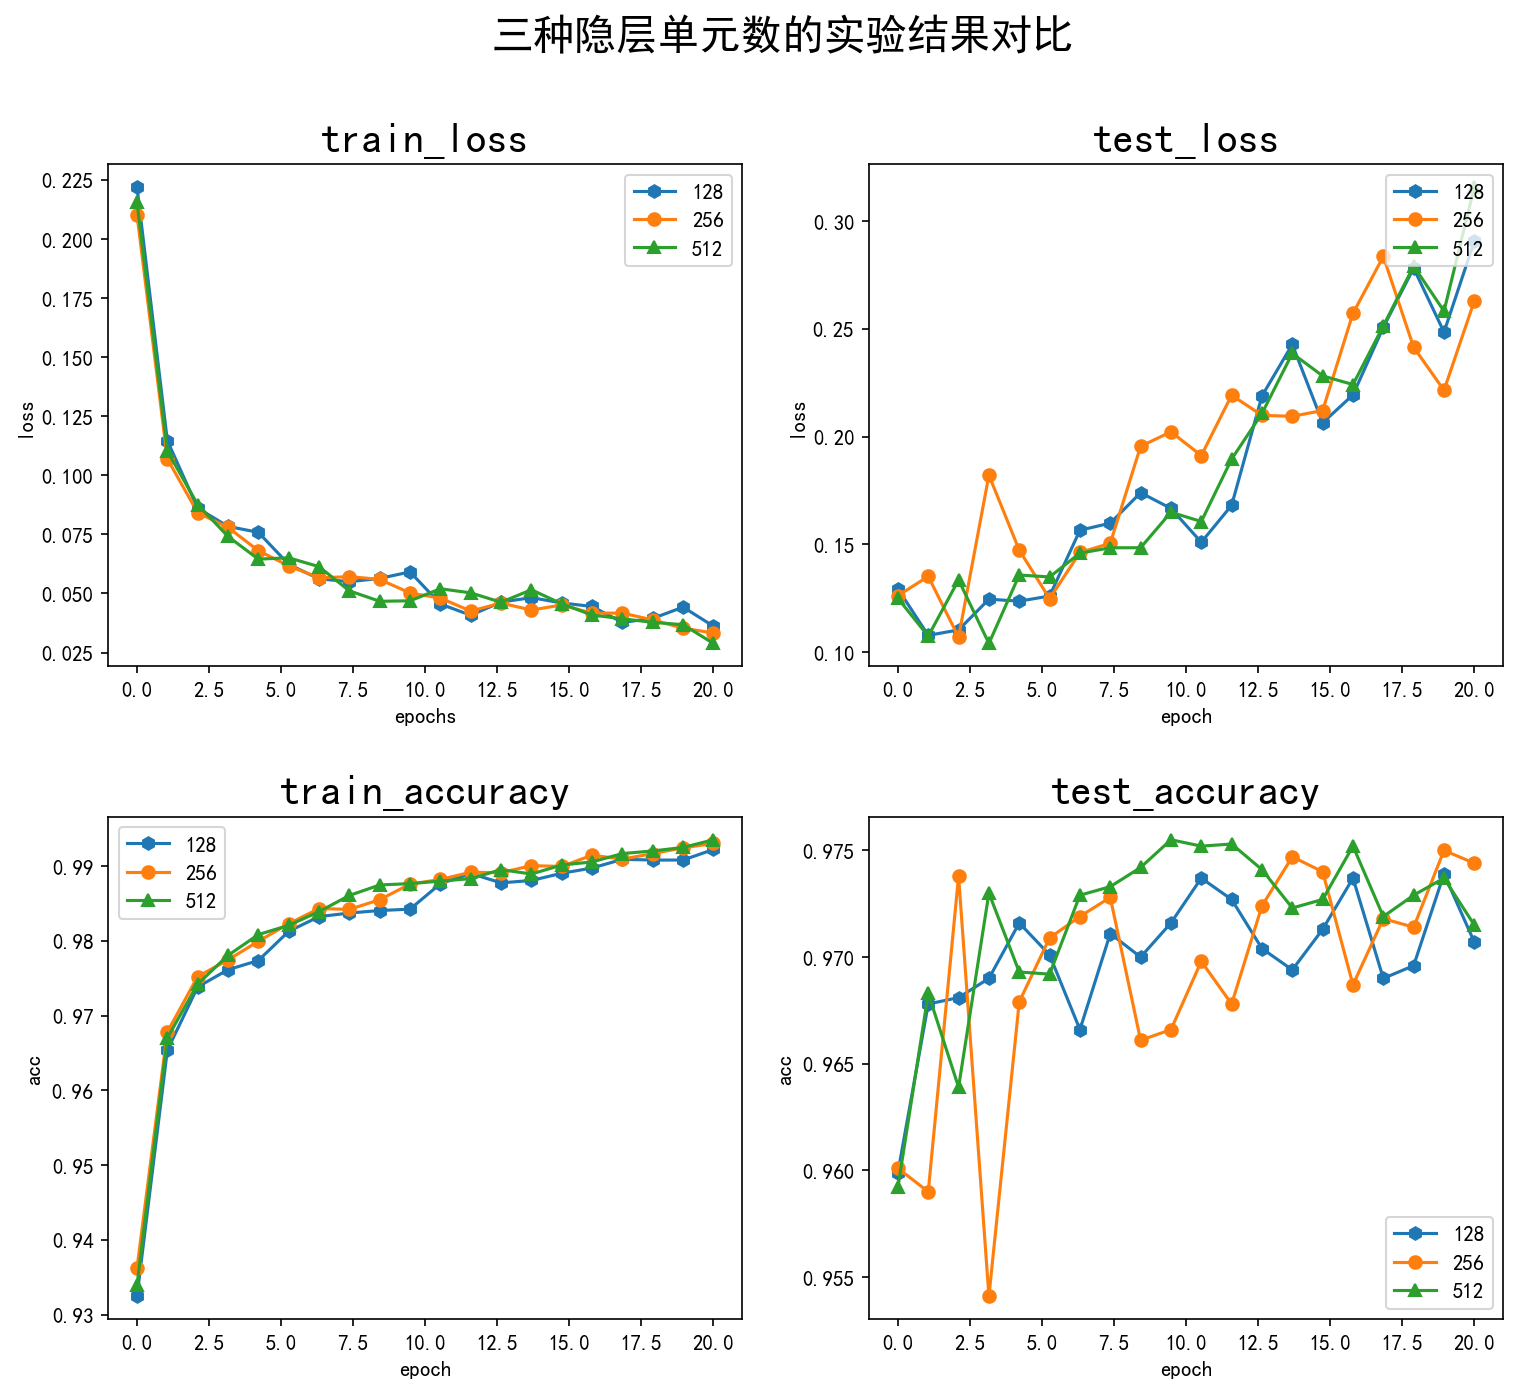

In [28]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("三种隐层单元数的实验结果对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses4), len(train_losses4))
ax1.plot(x, train_losses4, label="128", marker="h", linewidth=1.5)
ax1.plot(x, train_losses5, label="256", marker="o", linewidth=1.5)
ax1.plot(x, train_losses6, label="512", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses4, label="128", marker="h", linewidth=1.5)
ax2.plot(x, test_losses5, label="256", marker="o", linewidth=1.5)
ax2.plot(x, test_losses6, label="512", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc4, label="128", marker="h", linewidth=1.5)
ax3.plot(x, train_acc5, label="256", marker="o", linewidth=1.5)
ax3.plot(x, train_acc6, label="512", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc4, label="128", marker="h", linewidth=1.5)
ax4.plot(x, test_acc5, label="256", marker="o", linewidth=1.5)
ax4.plot(x, test_acc6, label="512", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

#### 结论
额~模型泛化性能很差

## 2.4 torch.nn实现四种优化器并进行对比实验

In [36]:
# 用sigmoid作激活函数
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        input_size, hidden_size, num_classes = 784, 256, 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.layer1(x.view(x.shape[0], -1)))
        out = self.layer2(out)
        return out


# 定义超参数和损失函数
num_epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()

### 2.4.1 SGD

In [37]:
model = FeedForwardNN()
optimizer = optim.SGD(model.parameters(), lr=lr)

train_losses_sgd, test_losses_sgd, train_acc_sgd, test_acc_sgd = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 2.2288,test_loss 2.0762 train acc 0.332 test acc 0.309
epoch 2, train_loss 2.0288,test_loss 1.7358 train acc 0.574 test acc 0.500
epoch 3, train_loss 1.7241,test_loss 1.5455 train acc 0.671 test acc 0.477
epoch 4, train_loss 1.3923,test_loss 1.2562 train acc 0.736 test acc 0.618
epoch 5, train_loss 1.1281,test_loss 1.0317 train acc 0.779 test acc 0.687
epoch 6, train_loss 0.9443,test_loss 0.8812 train acc 0.807 test acc 0.741
epoch 7, train_loss 0.8181,test_loss 0.7745 train acc 0.826 test acc 0.765
epoch 8, train_loss 0.7286,test_loss 0.6952 train acc 0.838 test acc 0.795
epoch 9, train_loss 0.6630,test_loss 0.6343 train acc 0.847 test acc 0.814
epoch 10, train_loss 0.6129,test_loss 0.5934 train acc 0.856 test acc 0.824
epoch 11, train_loss 0.5737,test_loss 0.5553 train acc 0.862 test acc 0.846
epoch 12, train_loss 0.5422,test_loss 0.5227 train acc 0.867 test acc 0.852
epoch 13, train_loss 0.5163,test_loss 0.4990 train acc 0.872 test acc 0.859
epoch 14, train_loss 

### 2.4.2 momentum优化器

In [38]:
momentum = 0.5
model = FeedForwardNN()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

(
    train_losses_momentum,
    test_losses_momentum,
    train_acc_momentum,
    test_acc_momentum,
) = train(model, train_loader, test_loader, loss, optimizer, num_epochs, lr)

epoch 1, train_loss 2.1400,test_loss 1.9911 train acc 0.419 test acc 0.362
epoch 2, train_loss 1.5827,test_loss 1.2754 train acc 0.698 test acc 0.643
epoch 3, train_loss 1.0499,test_loss 0.8855 train acc 0.789 test acc 0.733
epoch 4, train_loss 0.7799,test_loss 0.7001 train acc 0.829 test acc 0.787
epoch 5, train_loss 0.6422,test_loss 0.5923 train acc 0.851 test acc 0.829
epoch 6, train_loss 0.5612,test_loss 0.5297 train acc 0.864 test acc 0.852
epoch 7, train_loss 0.5082,test_loss 0.4809 train acc 0.872 test acc 0.863
epoch 8, train_loss 0.4708,test_loss 0.4478 train acc 0.879 test acc 0.872
epoch 9, train_loss 0.4434,test_loss 0.4240 train acc 0.883 test acc 0.876
epoch 10, train_loss 0.4224,test_loss 0.4053 train acc 0.887 test acc 0.882
epoch 11, train_loss 0.4057,test_loss 0.3900 train acc 0.889 test acc 0.884
epoch 12, train_loss 0.3923,test_loss 0.3788 train acc 0.893 test acc 0.891
epoch 13, train_loss 0.3810,test_loss 0.3677 train acc 0.895 test acc 0.894
epoch 14, train_loss 

### 2.4.3 rmsprop优化器

In [43]:
alpha = 0.9
model = FeedForwardNN()
optimizer = optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)
train_losses_rmsprop, test_losses_rmsprop, train_acc_rmsprop, test_acc_rmsprop = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 0.2625,test_loss 0.1249 train acc 0.920 test acc 0.962
epoch 2, train_loss 0.0927,test_loss 0.0926 train acc 0.972 test acc 0.970
epoch 3, train_loss 0.0618,test_loss 0.0864 train acc 0.981 test acc 0.976
epoch 4, train_loss 0.0461,test_loss 0.0957 train acc 0.986 test acc 0.973
epoch 5, train_loss 0.0348,test_loss 0.0858 train acc 0.988 test acc 0.979
epoch 6, train_loss 0.0282,test_loss 0.1003 train acc 0.991 test acc 0.977
epoch 7, train_loss 0.0226,test_loss 0.0979 train acc 0.992 test acc 0.976
epoch 8, train_loss 0.0186,test_loss 0.1023 train acc 0.994 test acc 0.979
epoch 9, train_loss 0.0143,test_loss 0.1002 train acc 0.995 test acc 0.979
epoch 10, train_loss 0.0121,test_loss 0.1092 train acc 0.996 test acc 0.979
epoch 11, train_loss 0.0112,test_loss 0.1049 train acc 0.996 test acc 0.981
epoch 12, train_loss 0.0087,test_loss 0.1243 train acc 0.997 test acc 0.979
epoch 13, train_loss 0.0083,test_loss 0.1253 train acc 0.997 test acc 0.979
epoch 14, train_loss 

### 2.4.4 Adam优化器

In [44]:
model = FeedForwardNN()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses_adam, test_losses_adam, train_acc_adam, test_acc_adam = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs, lr
)

epoch 1, train_loss 0.2601,test_loss 0.1270 train acc 0.921 test acc 0.960
epoch 2, train_loss 0.0991,test_loss 0.0980 train acc 0.969 test acc 0.967
epoch 3, train_loss 0.0666,test_loss 0.0830 train acc 0.979 test acc 0.974
epoch 4, train_loss 0.0503,test_loss 0.0773 train acc 0.984 test acc 0.976
epoch 5, train_loss 0.0396,test_loss 0.0974 train acc 0.987 test acc 0.971
epoch 6, train_loss 0.0333,test_loss 0.0799 train acc 0.989 test acc 0.975
epoch 7, train_loss 0.0258,test_loss 0.0791 train acc 0.991 test acc 0.977
epoch 8, train_loss 0.0250,test_loss 0.1140 train acc 0.991 test acc 0.966
epoch 9, train_loss 0.0279,test_loss 0.0885 train acc 0.991 test acc 0.975
epoch 10, train_loss 0.0244,test_loss 0.1052 train acc 0.992 test acc 0.971
epoch 11, train_loss 0.0222,test_loss 0.1140 train acc 0.992 test acc 0.972
epoch 12, train_loss 0.0214,test_loss 0.0976 train acc 0.992 test acc 0.975
epoch 13, train_loss 0.0229,test_loss 0.0968 train acc 0.992 test acc 0.975
epoch 14, train_loss 

### 2.4.5 四种优化器的实验结果对比

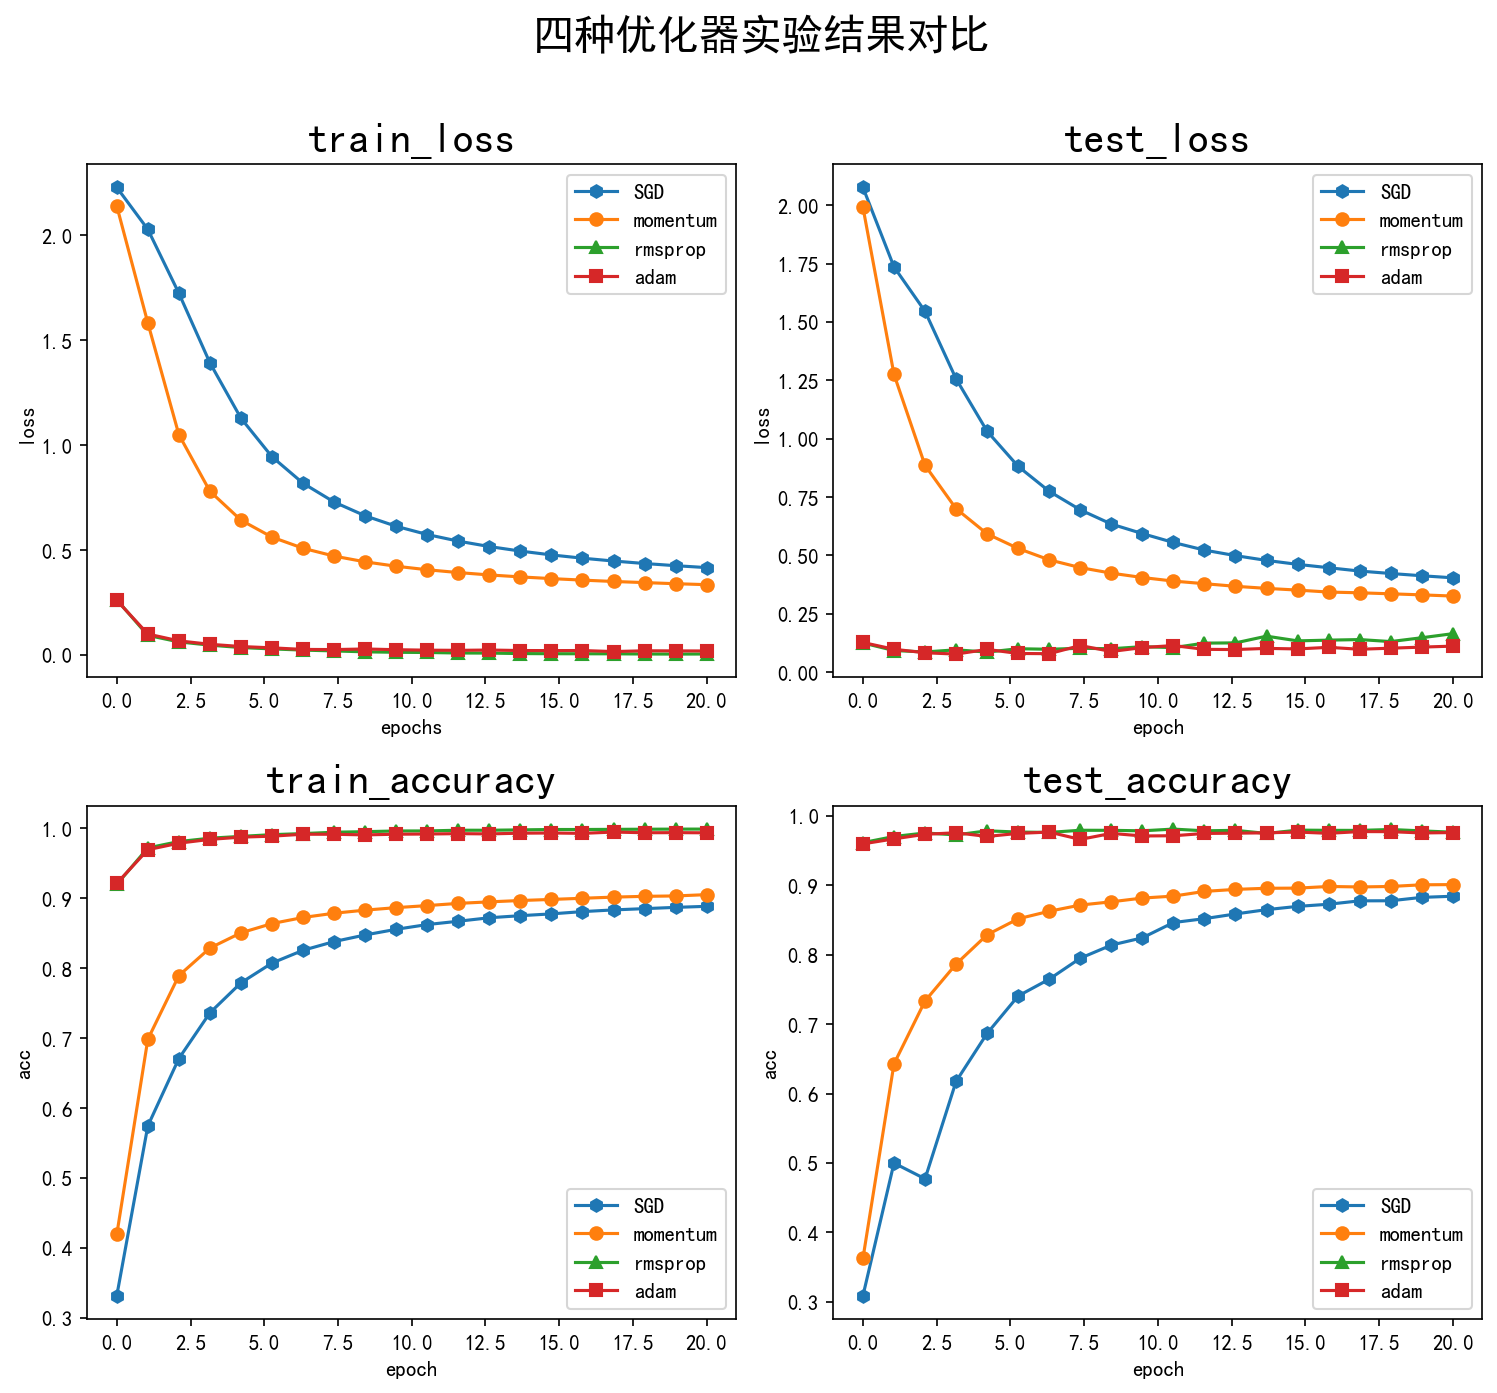

In [49]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.15, hspace=0.25)
fig.suptitle("四种优化器实验结果对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses_sgd), len(train_losses_sgd))
ax1.plot(x, train_losses_sgd, label="SGD", marker="h", linewidth=1.5)
ax1.plot(x, train_losses_momentum, label="momentum", marker="o", linewidth=1.5)
ax1.plot(x, train_losses_rmsprop, label="rmsprop", marker="^", linewidth=1.5)
ax1.plot(x, train_losses_adam, label="adam", marker="s", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses_sgd, label="SGD", marker="h", linewidth=1.5)
ax2.plot(x, test_losses_momentum, label="momentum", marker="o", linewidth=1.5)
ax2.plot(x, test_losses_rmsprop, label="rmsprop", marker="^", linewidth=1.5)
ax2.plot(x, test_losses_adam, label="adam", marker="s", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_sgd, label="SGD", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_momentum, label="momentum", marker="o", linewidth=1.5)
ax3.plot(x, train_acc_rmsprop, label="rmsprop", marker="^", linewidth=1.5)
ax3.plot(x, train_acc_adam, label="adam", marker="s", linewidth=1.5)

# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_sgd, label="SGD", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_momentum, label="momentum", marker="o", linewidth=1.5)
ax4.plot(x, test_acc_rmsprop, label="rmsprop", marker="^", linewidth=1.5)
ax4.plot(x, test_acc_adam, label="adam", marker="s", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

## 2.5 torch.nn实现L2正则化，进行乘法权重的对比实验

In [51]:
# 重新定义模型，添加惩罚权重
import torch.optim as optim


class FeedForwardNN(nn.Module):
    def __init__(self, weight_decay=0.001):
        super(FeedForwardNN, self).__init__()

        input_dim, hidden_dim, output_dim = 784, 256, 10
        self.weight_decay = weight_decay

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x.view(x.shape[0], -1))
        x = self.relu1(x)
        x = self.fc2(x)
        return x


# 在训练函数中计算L2正则化项
def trainL2(model, train_loader, test_loader, loss, optimizer, num_epochs):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    start = time.time()

    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0

        for X, y in train_loader:
            # 前向传播
            y_hat = model(X.view(-1, 784))
            # 计算损失
            l = loss(y_hat, y.flatten().long()).sum()
            # 添加L2正则项
            for param in model.parameters():
                l += model.weight_decay * torch.norm(param, p=2)
            # 反向传播
            l.backward()
            # 参数优化更新
            optimizer.step()
            # 梯度清零
            optimizer.zero_grad()

            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]

        # 计算每轮epoch的损失和准确率
        test_acc, test_loss_sum = evaluate_accuracy(test_loader, model, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_loss_list.append(test_loss_sum)
        test_acc_list.append(test_acc)

        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )

    end = time.time()
    print("\n总训练时间：%.2f秒" % (end - start))

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


num_epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()

### 2.5.1 weight_decay=0.001

In [52]:
model = FeedForwardNN()
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_L21, test_losses_L21, train_acc_L21, test_acc_L21 = trainL2(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.6973,test_loss 1.0298 train acc 0.663 test acc 0.723
epoch 2, train_loss 0.7710,test_loss 0.5898 train acc 0.841 test acc 0.841
epoch 3, train_loss 0.5417,test_loss 0.4674 train acc 0.870 test acc 0.866
epoch 4, train_loss 0.4602,test_loss 0.4094 train acc 0.884 test acc 0.883
epoch 5, train_loss 0.4178,test_loss 0.3768 train acc 0.891 test acc 0.890
epoch 6, train_loss 0.3912,test_loss 0.3563 train acc 0.897 test acc 0.895
epoch 7, train_loss 0.3722,test_loss 0.3377 train acc 0.901 test acc 0.902
epoch 8, train_loss 0.3576,test_loss 0.3256 train acc 0.904 test acc 0.904
epoch 9, train_loss 0.3460,test_loss 0.3150 train acc 0.907 test acc 0.905
epoch 10, train_loss 0.3359,test_loss 0.3075 train acc 0.910 test acc 0.909
epoch 11, train_loss 0.3272,test_loss 0.3005 train acc 0.912 test acc 0.910
epoch 12, train_loss 0.3194,test_loss 0.2923 train acc 0.914 test acc 0.914
epoch 13, train_loss 0.3121,test_loss 0.2859 train acc 0.917 test acc 0.914
epoch 14, train_loss 

### 2.5.2 weight_decay=0.005

In [53]:
model = FeedForwardNN(weight_decay=0.005)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_L22, test_losses_L22, train_acc_L22, test_acc_L22 = trainL2(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.7289,test_loss 1.0236 train acc 0.689 test acc 0.708
epoch 2, train_loss 0.8239,test_loss 0.5992 train acc 0.841 test acc 0.834
epoch 3, train_loss 0.6022,test_loss 0.4729 train acc 0.871 test acc 0.865
epoch 4, train_loss 0.5222,test_loss 0.4160 train acc 0.884 test acc 0.884
epoch 5, train_loss 0.4808,test_loss 0.3801 train acc 0.892 test acc 0.889
epoch 6, train_loss 0.4552,test_loss 0.3595 train acc 0.896 test acc 0.895
epoch 7, train_loss 0.4372,test_loss 0.3443 train acc 0.900 test acc 0.899
epoch 8, train_loss 0.4234,test_loss 0.3306 train acc 0.904 test acc 0.903
epoch 9, train_loss 0.4122,test_loss 0.3200 train acc 0.907 test acc 0.906
epoch 10, train_loss 0.4028,test_loss 0.3127 train acc 0.909 test acc 0.906
epoch 11, train_loss 0.3945,test_loss 0.3047 train acc 0.911 test acc 0.910
epoch 12, train_loss 0.3871,test_loss 0.2997 train acc 0.914 test acc 0.911
epoch 13, train_loss 0.3803,test_loss 0.2948 train acc 0.916 test acc 0.912
epoch 14, train_loss 

### 2.5.3 weight_decay=0.01

In [54]:
model = FeedForwardNN(weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_L23, test_losses_L23, train_acc_L23, test_acc_L23 = trainL2(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.7758,test_loss 1.0184 train acc 0.702 test acc 0.713
epoch 2, train_loss 0.8865,test_loss 0.5963 train acc 0.842 test acc 0.832
epoch 3, train_loss 0.6719,test_loss 0.4734 train acc 0.870 test acc 0.868
epoch 4, train_loss 0.5951,test_loss 0.4155 train acc 0.883 test acc 0.883
epoch 5, train_loss 0.5553,test_loss 0.3844 train acc 0.890 test acc 0.891
epoch 6, train_loss 0.5302,test_loss 0.3664 train acc 0.895 test acc 0.891
epoch 7, train_loss 0.5126,test_loss 0.3475 train acc 0.899 test acc 0.899
epoch 8, train_loss 0.4989,test_loss 0.3360 train acc 0.902 test acc 0.902
epoch 9, train_loss 0.4878,test_loss 0.3228 train acc 0.905 test acc 0.904
epoch 10, train_loss 0.4781,test_loss 0.3140 train acc 0.908 test acc 0.909
epoch 11, train_loss 0.4697,test_loss 0.3072 train acc 0.910 test acc 0.909
epoch 12, train_loss 0.4621,test_loss 0.2988 train acc 0.913 test acc 0.912
epoch 13, train_loss 0.4552,test_loss 0.2933 train acc 0.915 test acc 0.913
epoch 14, train_loss 

### 2.5.4 weight_decay=0.1

In [55]:
model = FeedForwardNN(weight_decay=0.1)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_L24, test_losses_L24, train_acc_L24, test_acc_L24 = trainL2(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 2.8984,test_loss 1.2074 train acc 0.640 test acc 0.677
epoch 2, train_loss 2.0562,test_loss 0.7172 train acc 0.820 test acc 0.807
epoch 3, train_loss 1.8168,test_loss 0.5770 train acc 0.856 test acc 0.842
epoch 4, train_loss 1.7171,test_loss 0.5152 train acc 0.872 test acc 0.861
epoch 5, train_loss 1.6530,test_loss 0.4801 train acc 0.881 test acc 0.869
epoch 6, train_loss 1.6033,test_loss 0.4590 train acc 0.886 test acc 0.879
epoch 7, train_loss 1.5615,test_loss 0.4463 train acc 0.889 test acc 0.882
epoch 8, train_loss 1.5242,test_loss 0.4383 train acc 0.892 test acc 0.886
epoch 9, train_loss 1.4906,test_loss 0.4322 train acc 0.894 test acc 0.886
epoch 10, train_loss 1.4597,test_loss 0.4280 train acc 0.896 test acc 0.889
epoch 11, train_loss 1.4315,test_loss 0.4244 train acc 0.897 test acc 0.891
epoch 12, train_loss 1.4051,test_loss 0.4237 train acc 0.898 test acc 0.891
epoch 13, train_loss 1.3811,test_loss 0.4214 train acc 0.899 test acc 0.893
epoch 14, train_loss 

### 2.5.5 四种惩罚权重的实验结果对比

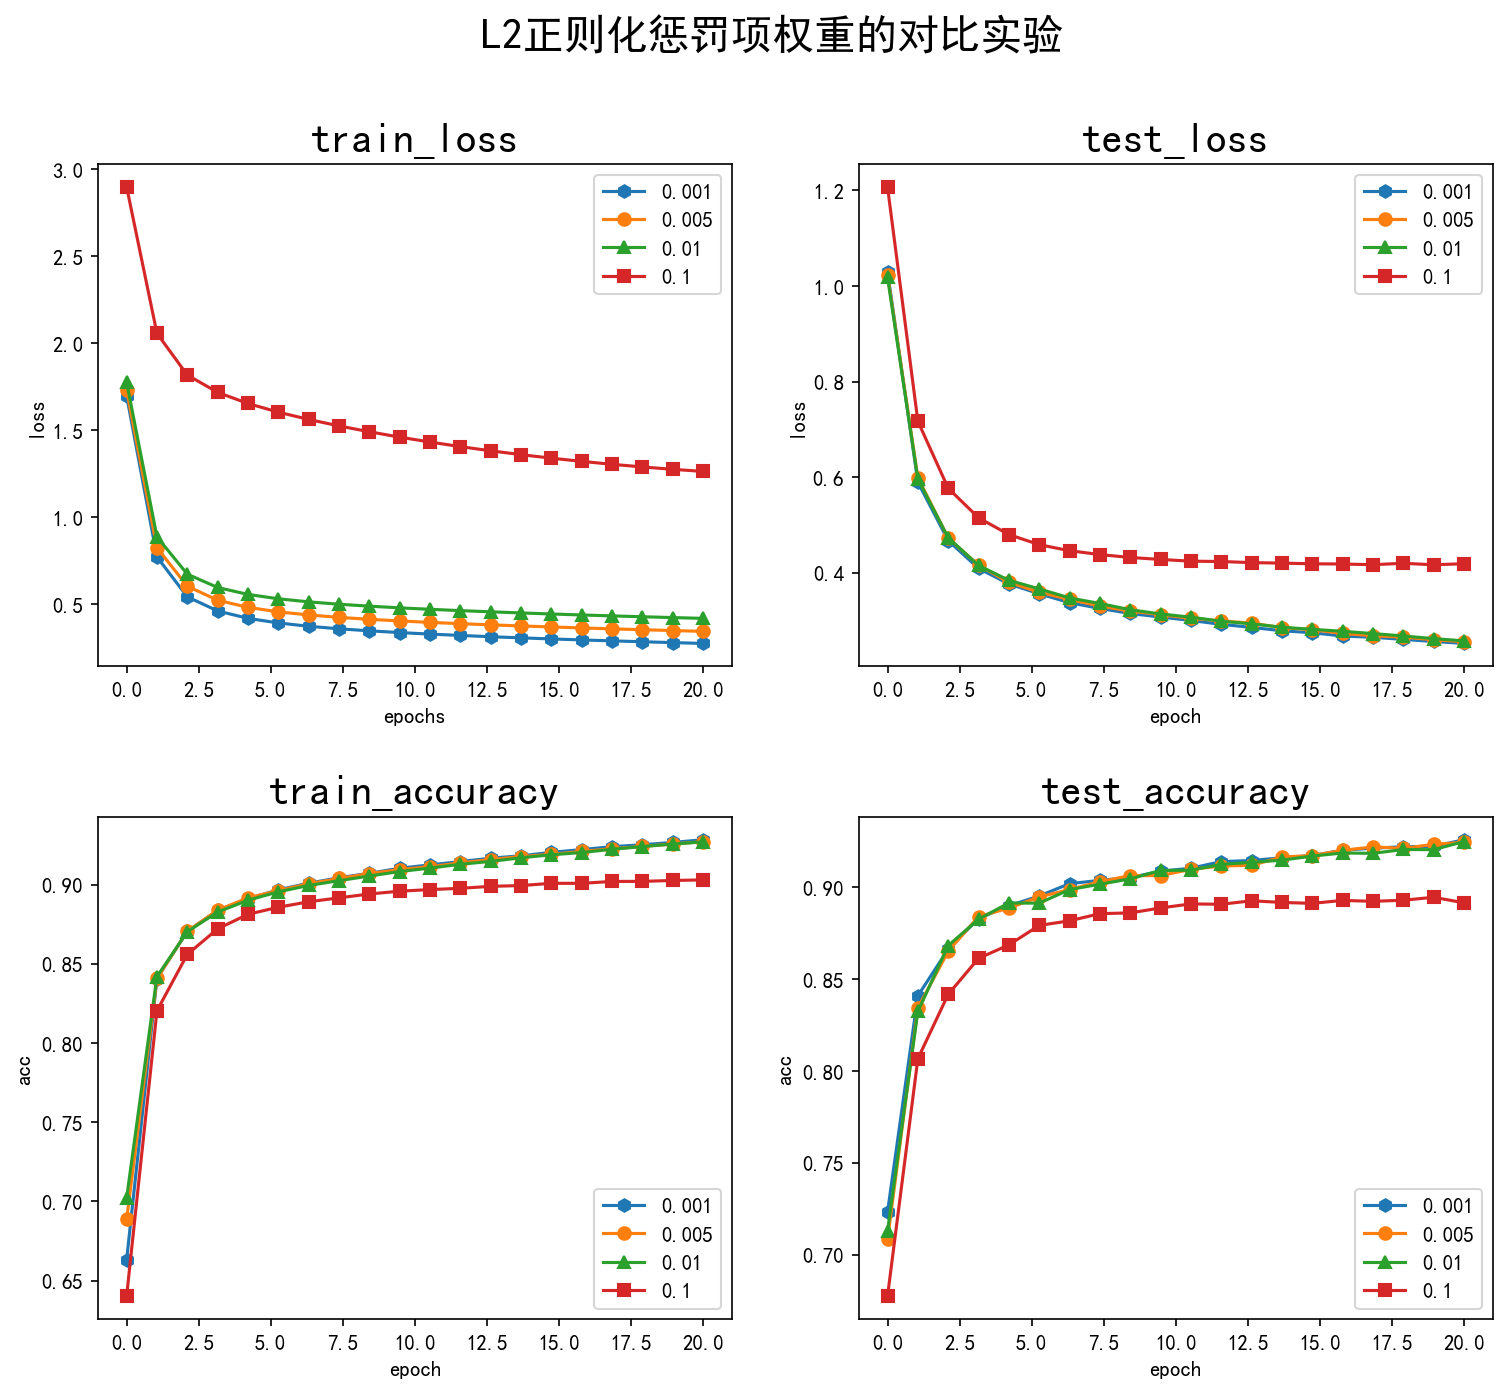

In [56]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("L2正则化惩罚项权重的对比实验", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses_L21), len(train_losses_L21))
ax1.plot(x, train_losses_L21, label="0.001", marker="h", linewidth=1.5)
ax1.plot(x, train_losses_L22, label="0.005", marker="o", linewidth=1.5)
ax1.plot(x, train_losses_L23, label="0.01", marker="^", linewidth=1.5)
ax1.plot(x, train_losses_L24, label="0.1", marker="s", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses_L21, label="0.001", marker="h", linewidth=1.5)
ax2.plot(x, test_losses_L22, label="0.005", marker="o", linewidth=1.5)
ax2.plot(x, test_losses_L23, label="0.01", marker="^", linewidth=1.5)
ax2.plot(x, test_losses_L24, label="0.1", marker="s", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_L21, label="0.001", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_L22, label="0.005", marker="o", linewidth=1.5)
ax3.plot(x, train_acc_L23, label="0.01", marker="^", linewidth=1.5)
ax3.plot(x, train_acc_L24, label="0.1", marker="s", linewidth=1.5)

# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_L21, label="0.001", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_L22, label="0.005", marker="o", linewidth=1.5)
ax4.plot(x, test_acc_L23, label="0.01", marker="^", linewidth=1.5)
ax4.plot(x, test_acc_L24, label="0.1", marker="s", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

## 2.6 torch.nn实现dropout，进行丢弃率的对比实验

In [63]:
# 重定义评估函数
def evaluate_accuracy(data_iter, model, loss_func):
    acc_sum, test_l_sum, n, c = 0.0, 0.0, 0.0, 0.0
    model = model.eval()
    for X, y in data_iter:
        # X,y=X.to('cuda'),y.to('cuda')
        result = model.forward(X)
        result = torch.round(result)
        acc_sum += (result.argmax(dim=1) == y.squeeze()).sum().item()
        test_l_sum += loss_func(result, y.flatten().long()).item()
        n += y.shape[0]
        c += 1
    return acc_sum / n, test_l_sum / c


# 定义模型框架，默认丢弃率为0.1
class FeedForwardNN_Drop(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(FeedForwardNN_Drop, self).__init__()
        input_dim, hidden_dim, output_dim = 784, 256, 10
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x.view(x.shape[0], -1))
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


num_epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()

### 2.6.1 drop_prob=0.1

In [64]:
model = FeedForwardNN_Drop()
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_drop1, test_losses_drop1, train_acc_drop1, test_acc_drop1 = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.6692,test_loss 1.0250 train acc 0.665 test acc 0.720
epoch 2, train_loss 0.7554,test_loss 0.5957 train acc 0.839 test acc 0.832
epoch 3, train_loss 0.5292,test_loss 0.4693 train acc 0.869 test acc 0.870
epoch 4, train_loss 0.4466,test_loss 0.4107 train acc 0.883 test acc 0.881
epoch 5, train_loss 0.4031,test_loss 0.3774 train acc 0.891 test acc 0.892
epoch 6, train_loss 0.3755,test_loss 0.3557 train acc 0.897 test acc 0.897
epoch 7, train_loss 0.3559,test_loss 0.3382 train acc 0.901 test acc 0.902
epoch 8, train_loss 0.3408,test_loss 0.3231 train acc 0.904 test acc 0.905
epoch 9, train_loss 0.3283,test_loss 0.3130 train acc 0.908 test acc 0.907
epoch 10, train_loss 0.3180,test_loss 0.3037 train acc 0.910 test acc 0.909
epoch 11, train_loss 0.3087,test_loss 0.2981 train acc 0.912 test acc 0.912
epoch 12, train_loss 0.3004,test_loss 0.2915 train acc 0.915 test acc 0.911
epoch 13, train_loss 0.2928,test_loss 0.2840 train acc 0.917 test acc 0.915
epoch 14, train_loss 

### 2.6.2 drop_prob=0.3

In [65]:
model = FeedForwardNN_Drop(dropout_prob=0.3)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_drop2, test_losses_drop2, train_acc_drop2, test_acc_drop2 = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.6956,test_loss 1.0536 train acc 0.624 test acc 0.711
epoch 2, train_loss 0.7674,test_loss 0.5993 train acc 0.843 test acc 0.839
epoch 3, train_loss 0.5310,test_loss 0.4709 train acc 0.871 test acc 0.870
epoch 4, train_loss 0.4475,test_loss 0.4154 train acc 0.883 test acc 0.882
epoch 5, train_loss 0.4042,test_loss 0.3804 train acc 0.891 test acc 0.888
epoch 6, train_loss 0.3769,test_loss 0.3585 train acc 0.896 test acc 0.893
epoch 7, train_loss 0.3578,test_loss 0.3408 train acc 0.900 test acc 0.900
epoch 8, train_loss 0.3430,test_loss 0.3279 train acc 0.904 test acc 0.904
epoch 9, train_loss 0.3307,test_loss 0.3168 train acc 0.907 test acc 0.908
epoch 10, train_loss 0.3204,test_loss 0.3081 train acc 0.910 test acc 0.909
epoch 11, train_loss 0.3114,test_loss 0.3008 train acc 0.912 test acc 0.912
epoch 12, train_loss 0.3033,test_loss 0.2933 train acc 0.914 test acc 0.911
epoch 13, train_loss 0.2959,test_loss 0.2865 train acc 0.916 test acc 0.915
epoch 14, train_loss 

### 2.6.3 drop_prob=0.5

In [66]:
model = FeedForwardNN_Drop(dropout_prob=0.5)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_drop3, test_losses_drop3, train_acc_drop3, test_acc_drop3 = train(
    model, train_loader, test_loader, loss, optimizer, num_epochs
)

epoch 1, train_loss 1.7131,test_loss 1.0653 train acc 0.598 test acc 0.698
epoch 2, train_loss 0.7702,test_loss 0.5999 train acc 0.840 test acc 0.834
epoch 3, train_loss 0.5309,test_loss 0.4713 train acc 0.870 test acc 0.870
epoch 4, train_loss 0.4472,test_loss 0.4121 train acc 0.883 test acc 0.882
epoch 5, train_loss 0.4039,test_loss 0.3789 train acc 0.891 test acc 0.889
epoch 6, train_loss 0.3765,test_loss 0.3584 train acc 0.896 test acc 0.894
epoch 7, train_loss 0.3572,test_loss 0.3401 train acc 0.900 test acc 0.902
epoch 8, train_loss 0.3423,test_loss 0.3271 train acc 0.904 test acc 0.903
epoch 9, train_loss 0.3299,test_loss 0.3184 train acc 0.907 test acc 0.905
epoch 10, train_loss 0.3196,test_loss 0.3069 train acc 0.910 test acc 0.907
epoch 11, train_loss 0.3106,test_loss 0.2988 train acc 0.912 test acc 0.912
epoch 12, train_loss 0.3022,test_loss 0.2910 train acc 0.915 test acc 0.913
epoch 13, train_loss 0.2946,test_loss 0.2845 train acc 0.917 test acc 0.916
epoch 14, train_loss 

### 2.6.4 不同丢弃率的实验结果对比

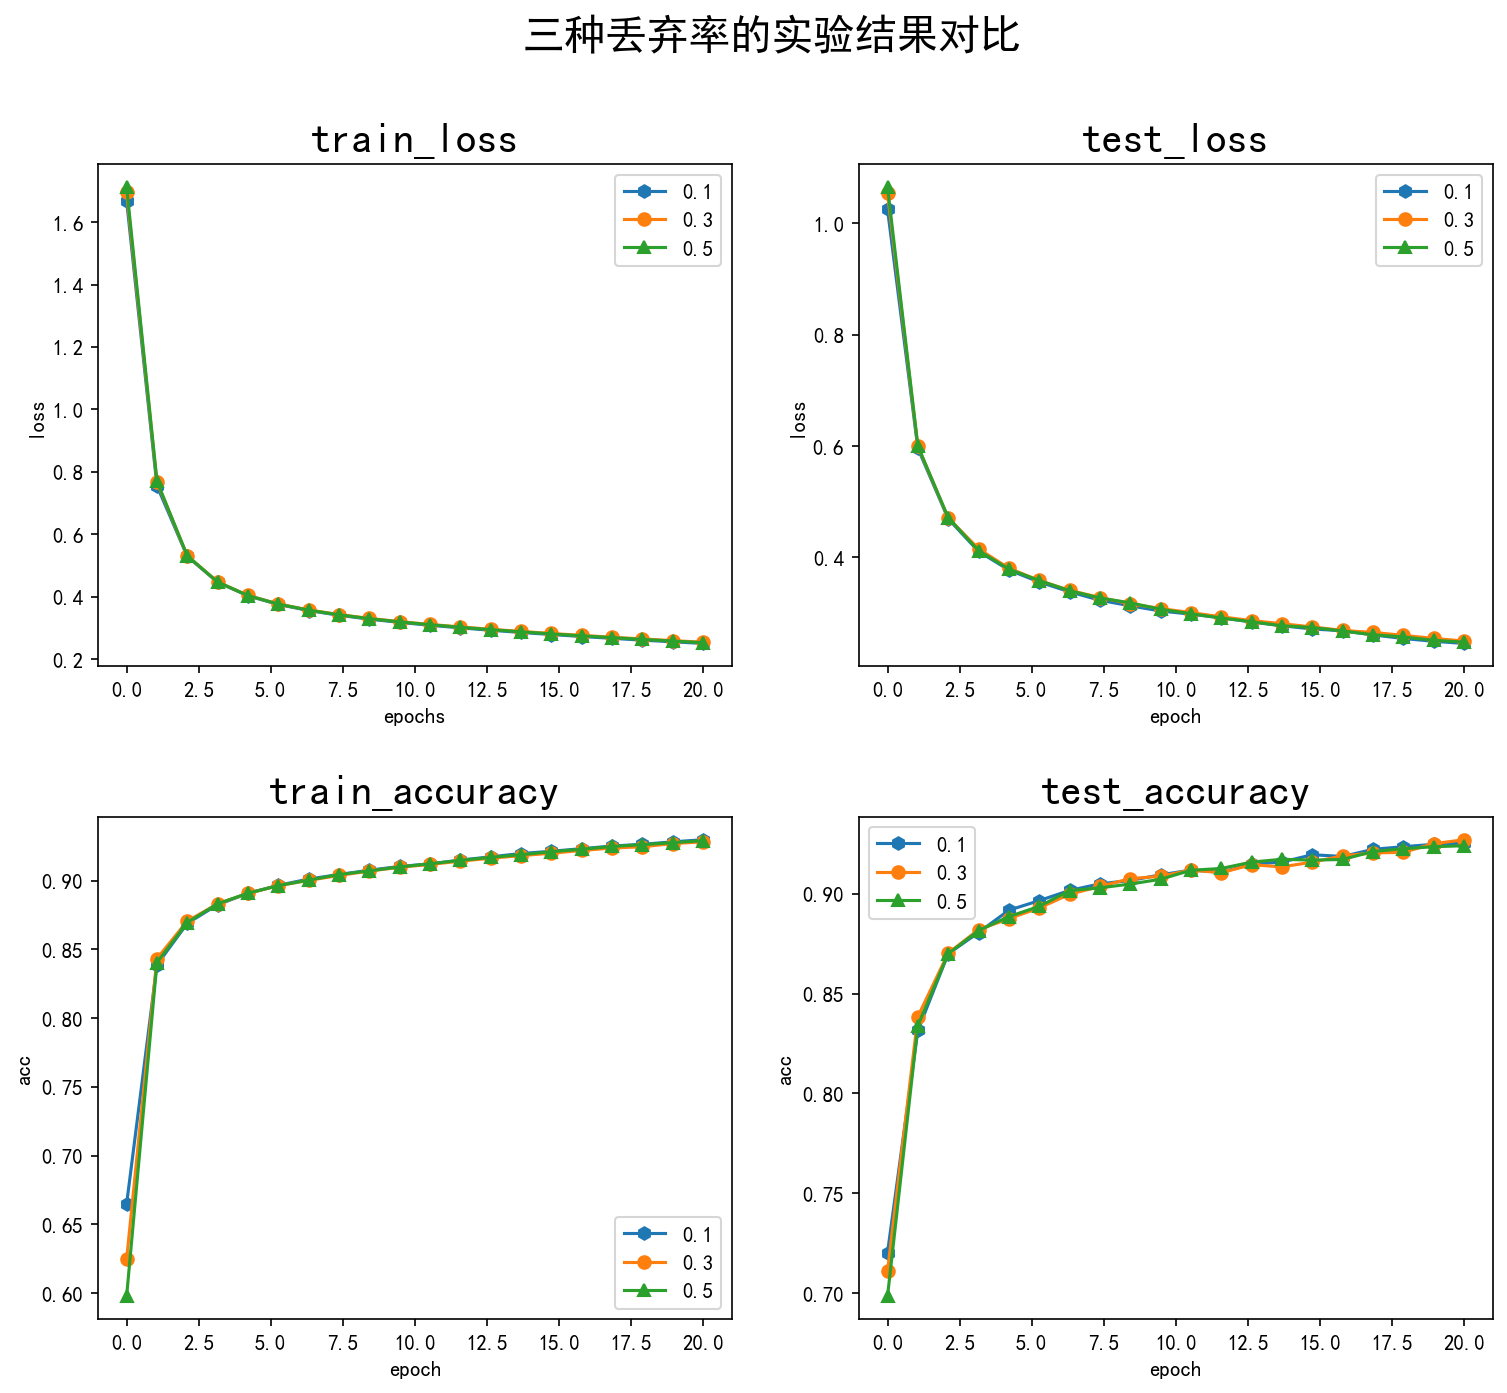

In [69]:
fig = plt.figure(figsize=(12, 10), dpi=150)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle("三种丢弃率的实验结果对比", fontsize=20)

# train loss
ax1 = fig.add_subplot(2, 2, 1)
x = np.linspace(0, len(train_losses_drop1), len(train_losses_drop1))
ax1.plot(x, train_losses_drop1, label="0.1", marker="h", linewidth=1.5)
ax1.plot(x, train_losses_drop2, label="0.3", marker="o", linewidth=1.5)
ax1.plot(x, train_losses_drop3, label="0.5", marker="^", linewidth=1.5)

# test loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, test_losses_drop1, label="0.1", marker="h", linewidth=1.5)
ax2.plot(x, test_losses_drop2, label="0.3", marker="o", linewidth=1.5)
ax2.plot(x, test_losses_drop3, label="0.5", marker="^", linewidth=1.5)

# train acc_list
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, train_acc_drop1, label="0.1", marker="h", linewidth=1.5)
ax3.plot(x, train_acc_drop2, label="0.3", marker="o", linewidth=1.5)
ax3.plot(x, train_acc_drop3, label="0.5", marker="^", linewidth=1.5)


# test acc_list
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, test_acc_drop1, label="0.1", marker="h", linewidth=1.5)
ax4.plot(x, test_acc_drop2, label="0.3", marker="o", linewidth=1.5)
ax4.plot(x, test_acc_drop3, label="0.5", marker="^", linewidth=1.5)

# x y 标题设置
ax1.set_title(
    "train_loss", fontproperties="SimHei", fontsize=20
)  # 为子图添加标题，设置标题的字体，字体的大小，字体的颜色
ax1.set_xlabel("epochs")  # 为x轴添加标签
ax1.set_ylabel("loss")  # 为y轴添加标签
ax1.legend(loc="upper right")  # 设置图表图例在右上角

ax2.set_title("test_loss", fontproperties="SimHei", fontsize=20)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(loc="upper right")

ax3.set_title("train_accuracy", fontproperties="SimHei", fontsize=20)
ax3.set_xlabel("epoch")
ax3.set_ylabel("acc")
ax3.legend(loc="best")

ax4.set_title("test_accuracy", fontproperties="SimHei", fontsize=20)
ax4.set_xlabel("epoch")
ax4.set_ylabel("acc")
ax4.legend(loc="best")

plt.show()

## 2.7 torch.nn实现早停

In [7]:
from sklearn.model_selection import train_test_split

train_dataset = torchvision.datasets.MNIST(
    root="./MNIST", train=True, transform=transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root="./MNIST", train=False, transform=transforms.ToTensor()
)
num_workers = 4
batch_size = 256
train_d, test_d = train_test_split(train_dataset, train_size=0.8, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    train_d, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    test_d, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [8]:
# 实现早停的类
class EarlyStopping:
    def __init__(self, save_path, patience=7, verbose=False, delta=0):
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        path = os.path.join(self.save_path, "best_network.pth")
        torch.save(model.state_dict(), path)  # 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

In [9]:
# 评价函数 准确率
def evaluate_accuracy(model, data_iter, loss_func):
    acc_sum, test_l_sum, n, c = 0.0, 0.0, 0.0, 0.0
    for X, y in data_iter:
        result = model.forward(X)
        result = torch.round(result)
        acc_sum += (result.argmax(dim=1) == y.squeeze()).sum().item()
        test_l_sum += loss_func(result, y.flatten().long()).item()
        n += y.shape[0]
        c += 1
    return acc_sum / n, test_l_sum / c

In [10]:
num_input, num_output, num_hiddens = 784, 10, 256


class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_input, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_output),
)
# net.to('cuda')
for params in net.parameters():
    torch.nn.init.normal_(params, mean=0, std=0.01)
loss = nn.CrossEntropyLoss()
import torch.optim as optim

lr = 0.05
optimizer = optim.SGD(net.parameters(), lr=lr)


# 训练函数
def train_early(
    net,
    train_loader,
    test_loader,
    val_loader,
    loss,
    num_epochs,
    lr=None,
    optimizer=None,
):
    train_loss_list = []
    test_loss_list = []
    val_loss_list = []
    train_acc_list = []
    test_acc_list = []
    val_acc_list = []
    save_path = ".\\"  # 当前目录下
    early_stopping = EarlyStopping(save_path, 5)
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        train_loss_sum, train_acc_sum, n, c = 0.0, 0.0, 0.0, 0.0
        for X, y in train_loader:
            # X,y=X.to('cuda', non_blocking=True),y.to('cuda', non_blocking=True)
            y_hat = net.forward(X)
            l = loss(y_hat, y.flatten().long())
            # 梯度清零
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y.squeeze()).sum().item()
            c += 1
            n += y.shape[0]
        test_acc, test_loss_sum = evaluate_accuracy(net, test_loader, loss)
        val_acc, val_loss_sum = evaluate_accuracy(net, val_loader, loss)
        train_loss_list.append(train_loss_sum / c)
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss_sum)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss_sum)
        print(
            "epoch %d, train_loss %.4f,test_loss %.4f train acc %.3f test acc %.3f"
            % (
                epoch + 1,
                train_loss_sum / c,
                test_loss_sum,
                train_acc_sum / n,
                test_acc,
            )
        )
        print("val_loss %.4f val acc %.3f " % (val_loss_sum, val_acc))
        early_stopping(val_loss_sum, net)
        # 达到早停止条件时，early_stop会被置为True
        if early_stopping.early_stop:
            print("Early stopping")
            break  # 跳出迭代，结束训练
    return (
        train_loss_list,
        test_loss_list,
        val_loss_list,
        train_acc_list,
        test_acc_list,
        val_acc_list,
    )

In [11]:
num_epochs = 200
(
    train_loss_list_E,
    test_loss_list_E,
    val_loss_list_E,
    train_acc_list_E,
    test_acc_list_E,
    val_acc_list_E,
) = train_early(
    net, train_loader, test_loader, val_loader, loss, num_epochs, lr, optimizer
)

epoch 1, train_loss 1.7414,test_loss 0.8952 train acc 0.617 test acc 0.721
val_loss 0.9159 val acc 0.708 
epoch 2, train_loss 0.6407,test_loss 0.4944 train acc 0.843 test acc 0.848
val_loss 0.5120 val acc 0.844 
epoch 3, train_loss 0.4471,test_loss 0.3950 train acc 0.881 test acc 0.880
val_loss 0.4147 val acc 0.875 
epoch 4, train_loss 0.3848,test_loss 0.3513 train acc 0.893 test acc 0.895
val_loss 0.3709 val acc 0.892 
epoch 5, train_loss 0.3521,test_loss 0.3296 train acc 0.901 test acc 0.900
val_loss 0.3448 val acc 0.897 
epoch 6, train_loss 0.3304,test_loss 0.3114 train acc 0.906 test acc 0.908
val_loss 0.3260 val acc 0.906 
epoch 7, train_loss 0.3136,test_loss 0.2963 train acc 0.911 test acc 0.910
val_loss 0.3113 val acc 0.908 
epoch 8, train_loss 0.2993,test_loss 0.2875 train acc 0.914 test acc 0.914
val_loss 0.3006 val acc 0.911 
epoch 9, train_loss 0.2870,test_loss 0.2750 train acc 0.918 test acc 0.918
val_loss 0.2908 val acc 0.914 
epoch 10, train_loss 0.2753,test_loss 0.2656 t

KeyboardInterrupt: 